# **Arabica Coffee Sensory Analysis and Predictive Modeling**



שמות המגישות:

אור מגר - 208597351

ענבר בבאי - 307838284



 תאריך הגשה:
 31.07.2025

הקוד הבא מבצע תהליך מלא של ניתוח נתונים לטבלת דירוגי טעימות קפה מסוג ערביקה.

תחילה בוצע ניקוי יסודי של הדאטה, הכולל סינון עמודות לא רלוונטיות, טיפול בערכים
חסרים ואחידות ביחידות מדידה.

לאחר מכן נערך ניתוח מקדים לשם הבנת מבנה הדאטה, התפלגויות המשתנים, זיהוי דפוסים חריגים ובחינת קשרים בין משתנים סנסוריים וטכניים.

בשלב המתקדם בוצעה בניית מודלים סטטיסטיים ותחזיתיים – רגרסיה לינארית מרובת משתנים  ומודל ריגרסיה לא לינארי במטרה להעריך את התרומה היחסית של כל משתנה לציון הסנסורי  ולבחון את קיומן של אינטראקציות לא לינאריות והשפעות עקיפות כמו אפקט מוניטין.


קישור למערך הנתונים - [link text](https://github.com/jldbc/coffee-quality-database/tree/master)

## ניקוי נתונים

### טעינת הדאטה וייבוא סיפריות

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# Importing libraries
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical plotting
from IPython.display import display  # Pretty printing in notebooks
from scipy import stats  # Statistical tests and distributions

In [105]:
# Load the dataset
file_path = '/content/drive/MyDrive/Data_Project/arabica_ratings_raw.csv'
df = pd.read_csv(file_path)

### ניקוי הטבלה
הורדת עמודות בהם היו יותר מ700 ערכי NAN
הורדת עמודות לא רלוונטיות לשאלת המחקר שלנו
איחוד בין עמודות זהות

In [106]:
# Count total number of rows in the dataset
num_rows = df.shape[0]

# Drop columns with more than 700 missing values
threshold = 700
df_cleaned = df.dropna(axis=1, thresh=num_rows - threshold)

# Drop columns where all values are identical (including NaNs)
for col in df_cleaned.columns:
    if df_cleaned[col].nunique(dropna=False) == 1:
        df_cleaned.drop(columns=col, inplace=True)

# Drop specific columns requested by the user
columns_to_drop = [
    'Owner.1', 'Number of Bags', 'Bag Weight', 'NA', 'Mill',
    'Category One Defects', 'Quakers', 'Category Two Defects',
    'Certification Body', 'Certification Address', 'Certification Contact',
    'In-Country Partner'
]
df_cleaned = df_cleaned.drop(columns=[col for col in columns_to_drop if col in df_cleaned.columns])

# Show the remaining columns and shape of the cleaned dataset
print("Remaining columns:", df_cleaned.columns.tolist())
print("Shape after cleaning:", df_cleaned.shape)

Remaining columns: ['Unnamed: 0', 'quality_score', 'Owner', 'Country of Origin', 'Farm Name', 'ICO Number', 'Company', 'Altitude', 'Region', 'Producer', 'Harvest Year', 'Grading Date', 'Variety', 'Processing Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points', 'Total Cup Points', 'Moisture', 'Color', 'Expiration']
Shape after cleaning: (1312, 28)


/tmp/ipython-input-1992444743.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=col, inplace=True)
/tmp/ipython-input-1992444743.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=col, inplace=True)
/tmp/ipython-input-1992444743.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=col, inplace=True)


### נרמול ושינוי
נרמול של הגובה ליחידות מידה של מטר
אחידות של התאריכים
הורדת אותיות באנגלית במשתנים נומרים
אחידות של אותיות קטנות

count    1312.000000
mean     1323.244409
std       346.238223
min       600.000000
25%      1100.000000
50%      1310.640000
75%      1600.000000
max      2500.000000
Name: Altitude (m), dtype: float64

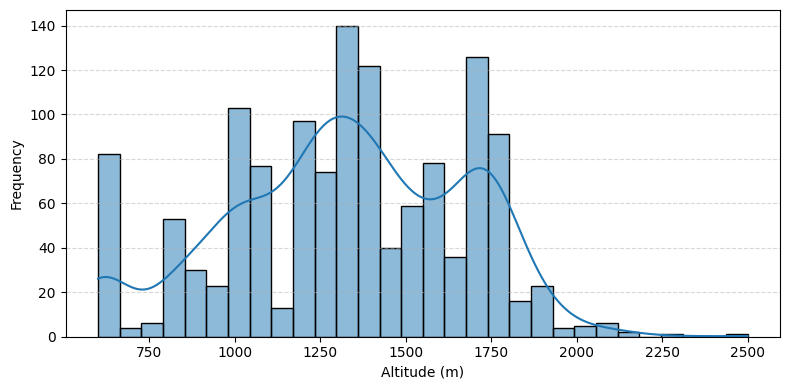

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to normalize altitude values to meters
def convert_altitude(value):
    """
    Normalize altitude values to meters based on textual patterns and logic:

    - Handles ranges (e.g. '1600 - 1800 m', '4500-6000 ft')
    - Recognizes units: meters (m, msnm, metros, meters, sea level), feet (ft, feet)
    - Assumes meters for values in the range 800-2500 if no unit is specified
    - Converts values above 2500 without units to meters assuming they are feet
    - Converts values between 0.8-2.5 to meters assuming they are in kilometers
    - Cleans all results to numeric only (no letters)
    """
    if pd.isnull(value):
        return np.nan

    value_str = str(value).replace(',', '').strip().lower()
    value_str = value_str.replace(':', '')

    try:
        # Handle ranges
        if '-' in value_str:
            parts = value_str.split('-')
            nums = []
            for part in parts:
                clean = ''.join(filter(lambda x: x.isdigit() or x == '.', part))
                if clean:
                    nums.append(float(clean))
            if len(nums) == 2:
                avg = sum(nums) / 2
                if any(unit in value_str for unit in ['m', 'meter', 'metros', 'msnm', 'sea level']):
                    return avg
                elif 'ft' in value_str or 'feet' in value_str:
                    return round(avg * 0.3048, 2)
                elif 800 <= avg <= 2500:
                    return avg
                else:
                    return round(avg * 0.3048, 2)

        # Handle single value
        num = float(''.join(filter(lambda x: x.isdigit() or x == '.', value_str)))

        # Convert km to meters
        if 0.8 <= num <= 2.5:
            num *= 1000

        if num > 2500 and not any(unit in value_str for unit in ['m', 'meter', 'metros', 'msnm', 'sea level', 'ft', 'feet']):
            return round(num * 0.3048, 2)

        if any(unit in value_str for unit in ['m', 'meter', 'metros', 'msnm', 'sea level']):
            return num if num > 100 else np.nan

        if 'ft' in value_str or 'feet' in value_str:
            return round(num * 0.3048, 2)

        if 800 <= num <= 2500:
            return num
        else:
            return round(num * 0.3048, 2)

    except:
        return np.nan

# Apply conversion to cleaned altitude
df_cleaned['Altitude (m)'] = df_cleaned['Altitude'].apply(convert_altitude)
df_cleaned.drop(columns='Altitude', inplace=True)

# Handle out-of-range or missing values
df_cleaned['Altitude (m)'] = df_cleaned['Altitude (m)'].apply(
    lambda x: x if pd.isnull(x) or (600 <= x <= 3000) else np.nan
)

# Fill missing altitudes using per-country median, then global fallback
df_cleaned['Altitude (m)'] = df_cleaned.groupby('Country of Origin')['Altitude (m)'].transform(
    lambda x: x.fillna(x.median())
)
df_cleaned['Altitude (m)'] = df_cleaned['Altitude (m)'].fillna(df_cleaned['Altitude (m)'].median())

# Display stats
display(df_cleaned['Altitude (m)'].describe())

# Plot distribution
plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['Altitude (m)'], bins=30, kde=True)
plt.xlabel('Altitude (m)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [108]:
# Convert 'Grading Date' to datetime
df_cleaned['Grading Date'] = pd.to_datetime(df_cleaned['Grading Date'], errors='coerce')

# Clean 'Total Cup Points' to retain numeric values only
df_cleaned['Total Cup Points'] = df_cleaned['Total Cup Points'].apply(
    lambda x: pd.to_numeric(''.join(filter(lambda c: c.isdigit() or c == '.', str(x))), errors='coerce')
)

# Clean 'Moisture': remove '%' and rename column
df_cleaned['Moisture (%)'] = df_cleaned['Moisture'].apply(
    lambda x: float(str(x).replace('%', '').strip()) if pd.notnull(x) else np.nan
)
df_cleaned.drop(columns='Moisture', inplace=True)

# Convert 'Expiration' to datetime
df_cleaned['Expiration'] = pd.to_datetime(df_cleaned['Expiration'], errors='coerce')

# Standardize text columns: lowercase and strip spaces
for col in ['Company', 'Region', 'Farm Name', 'Producer']:
    df_cleaned[col] = df_cleaned[col].str.lower().str.strip()

# Display the first 5 rows of the cleaned dataframe
display(df_cleaned.head(5))


Unnamed: 0  quality_score                     Owner Country of Origin  \
0           0          90.58                 metad plc          Ethiopia   
1           1          89.92                 metad plc          Ethiopia   
2           2          89.75  Grounds for Health Admin         Guatemala   
3           3          89.00       Yidnekachew Dabessa          Ethiopia   
4           4          88.83                 metad plc          Ethiopia   

                                  Farm Name ICO Number  \
0                                 metad plc  2014/2015   
1                                 metad plc  2014/2015   
2  san marcos barrancas "san cristobal cuch        NaN   
3     yidnekachew dabessa coffee plantation        NaN   
4                                 metad plc  2014/2015   

                                 Company                    Region  \
0      metad agricultural developmet plc         guji-hambela/goyo   
1      metad agricultural developmet plc        guji-hambela/alaka   
2                                    NaN                       NaN   
3  yidnekachew debessa coffee plantation                    oromia   
4      metad agricultural developmet plc  guji-hambela/bishan fugu   

                                Producer Harvest Year  ... Balance Uniformity  \
0                              metad plc         2014  ...    8.42       10.0   
1                              metad plc         2014  ...    8.42       10.0   
2                                    NaN          NaN  ...    8.42       10.0   
3  yidnekachew dabessa coffee plantation         2014  ...    8.25       10.0   
4                              metad plc         2014  ...    8.33       10.0   

  Clean Cup  Sweetness  Cupper Points  Total Cup Points  Color  Expiration  \
0      10.0       10.0           8.75             90.58  Green  2016-04-03   
1      10.0       10.0           8.58             89.92  Green  2016-04-03   
2      10.0       10.0           9.25             89.75    NaN         NaT   
3      10.0       10.0           8.67             89.00  Green         NaT   
4      10.0       10.0           8.58             88.83  Green  2016-04-03   

   Altitude (m)  Moisture (%)  
0        2075.0          12.0  
1        2075.0          12.0  
2        1700.0           0.0  
3        2000.0          11.0  
4        2075.0          12.0  

[5 rows x 28 columns]

### בדיקה של ערכים חסרים
נבדוק איזה עמודות כוללות את מספר הערכים החסרים הגדול ביותר ובכמה שורות מדובר (%)
על ידי כך נבין האם ניתן להסיר אותן- אם הן לא רלוונטיות לשאלת המחקר והאחוז גדול נחסיר

In [109]:
# Count missing values per column
missing_counts = df_cleaned.isnull().sum()

# Calculate percentage of missing values
missing_percent = (missing_counts / len(df_cleaned)) * 100

# Combine into a single DataFrame
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing (%)': missing_percent.round(2)
})

# Filter to show only columns that have missing values
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

# Display the result
display(missing_summary)


Missing Values  Missing (%)
Owner                           7         0.53
Country of Origin               1         0.08
Farm Name                     356        27.13
ICO Number                    148        11.28
Company                       210        16.01
Region                         56         4.27
Producer                      230        17.53
Harvest Year                   47         3.58
Grading Date                  288        21.95
Variety                       202        15.40
Processing Method             153        11.66
Color                         268        20.43
Expiration                   1238        94.36

## EDA

### התפלגות הציונים

#### חלוקה לציונים איכותיים

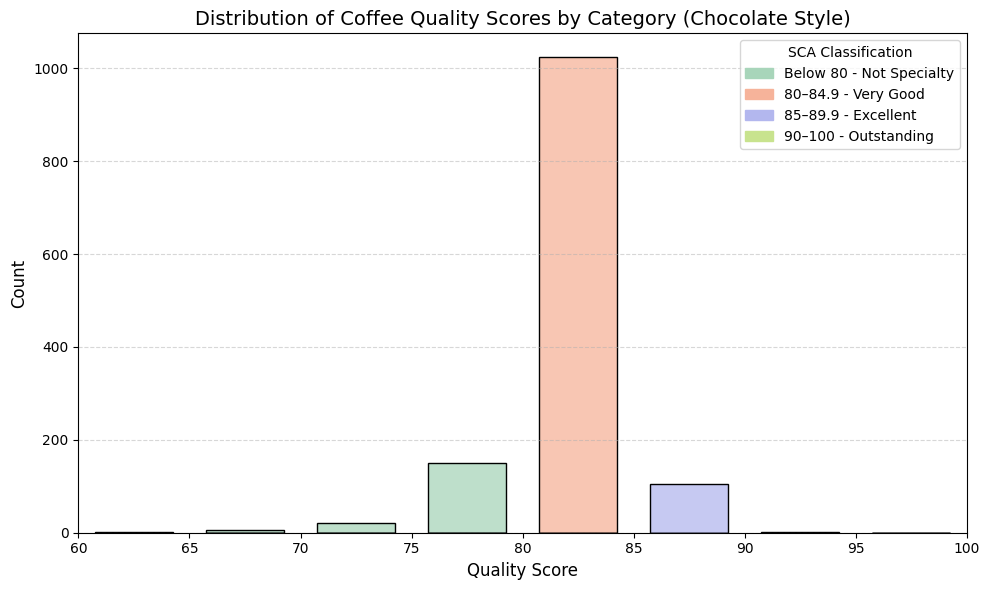

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

# Define bins manually
bin_edges = np.arange(60, 101, 5)  # bins of width 5

# Classify each row into SCA category
def classify_sca(score):
    if pd.isna(score):
        return 'Missing'
    elif score < 80:
        return 'Not Specialty'
    elif score < 85:
        return 'Very Good'
    elif score < 90:
        return 'Excellent'
    elif score <= 100:
        return 'Outstanding'
    else:
        return 'Invalid'

df_cleaned['SCA Category'] = df_cleaned['quality_score'].apply(classify_sca)

# Define color palette and category order
category_palette = {
    'Not Specialty': '#A8D5BA',
    'Very Good': '#F6B39A',
    'Excellent': '#B3B7EE',
    'Outstanding': '#C8E38E'
}

category_order = ['Not Specialty', 'Very Good', 'Excellent', 'Outstanding']

# Create figure
plt.figure(figsize=(10, 6))

# Plot each category separately
for category in category_order:
    subset = df_cleaned[df_cleaned['SCA Category'] == category]
    sns.histplot(
        data=subset,
        x='quality_score',
        bins=bin_edges,
        color=category_palette[category],
        edgecolor='black',
        label=category,
        element='bars',
        shrink=0.7
    )

# Axis formatting
plt.title('Distribution of Coffee Quality Scores by Category (Chocolate Style)', fontsize=14)
plt.xlabel('Quality Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(np.arange(60, 101, 5))
plt.xlim(60, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Legend with explanations
category_descriptions = {
    'Not Specialty': 'Below 80 - Not Specialty',
    'Very Good': '80–84.9 - Very Good',
    'Excellent': '85–89.9 - Excellent',
    'Outstanding': '90–100 - Outstanding'
}

custom_legend = [
    mpatches.Patch(color=category_palette[label], label=category_descriptions[label])
    for label in category_order
]

plt.legend(
    handles=custom_legend,
    title='SCA Classification',
    loc='upper right'
)

plt.tight_layout()
plt.show()


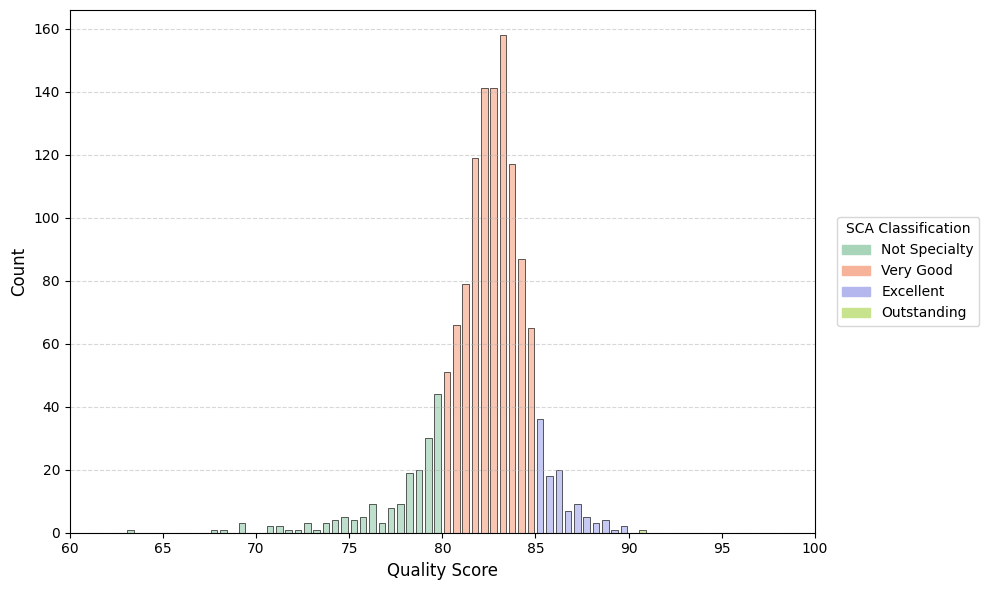

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

# Simple SCA category function
def classify_sca(score):
    if pd.isna(score):
        return 'Missing'
    elif score < 80:
        return 'Not Specialty'
    elif score < 85:
        return 'Very Good'
    elif score < 90:
        return 'Excellent'
    elif score <= 100:
        return 'Outstanding'
    else:
        return 'Invalid'

df_cleaned['SCA Category'] = df_cleaned['quality_score'].apply(classify_sca)

# Color palette
category_palette = {
    'Not Specialty': '#A8D5BA',
    'Very Good': '#F6B39A',
    'Excellent': '#B3B7EE',
    'Outstanding': '#C8E38E'
}

# Category order
category_order = ['Not Specialty', 'Very Good', 'Excellent', 'Outstanding']

# Plot
plt.figure(figsize=(10, 6))
bin_edges = np.arange(60, 101, 0.5)  # fine binning for smooth internal view

for category in category_order:
    subset = df_cleaned[df_cleaned['SCA Category'] == category]
    sns.histplot(
        data=subset,
        x='quality_score',
        bins=bin_edges,
        color=category_palette[category],
        edgecolor='black',
        label=category,
        element='bars',
        shrink=0.7
    )

# Axis formatting
plt.xlabel('Quality Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(np.arange(60, 101, 5))
plt.xlim(60, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Legend
custom_legend = [
    mpatches.Patch(color=category_palette[label], label=label)
    for label in category_order
]

plt.legend(
    handles=custom_legend,
    title='SCA Classification',
    bbox_to_anchor=(1.02, 0.5),
    loc='center left'
)

plt.tight_layout()
plt.show()

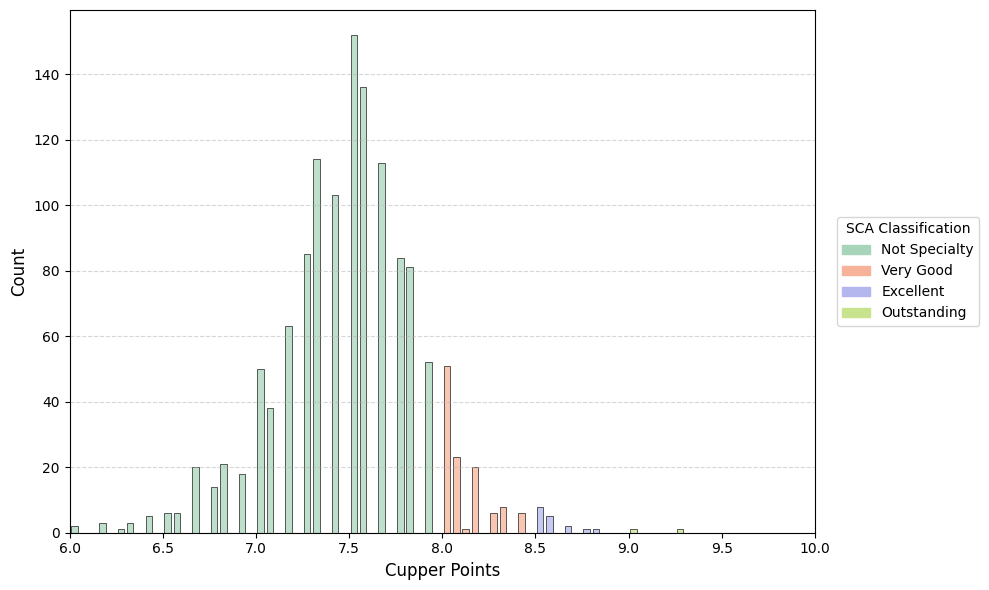

In [112]:
# Classify Cupper Points using same SCA logic (on 6–10 scale)
def classify_cupper(score):
    if pd.isna(score):
        return 'Missing'
    elif score < 8.0:
        return 'Not Specialty'
    elif score < 8.5:
        return 'Very Good'
    elif score < 9.0:
        return 'Excellent'
    elif score <= 10.0:
        return 'Outstanding'
    else:
        return 'Invalid'

df_cleaned['Cupper Category'] = df_cleaned['Cupper Points'].apply(classify_cupper)

# Plot Cupper Points histogram by category
plt.figure(figsize=(10, 6))
bin_edges = np.arange(6, 10.1, 0.05)  # finer bins between 6 and 10

for category in category_order:
    subset = df_cleaned[df_cleaned['Cupper Category'] == category]
    sns.histplot(
        data=subset,
        x='Cupper Points',
        bins=bin_edges,
        color=category_palette[category],
        edgecolor='black',
        label=category,
        element='bars',
        shrink=0.7
    )

# Axis formatting
plt.xlabel('Cupper Points', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(np.arange(6, 10.1, 0.5))
plt.xlim(6, 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Legend
custom_legend = [
    mpatches.Patch(color=category_palette[label], label=label)
    for label in category_order
]

plt.legend(
    handles=custom_legend,
    title='SCA Classification',
    bbox_to_anchor=(1.02, 0.5),
    loc='center left'
)

plt.tight_layout()
plt.show()

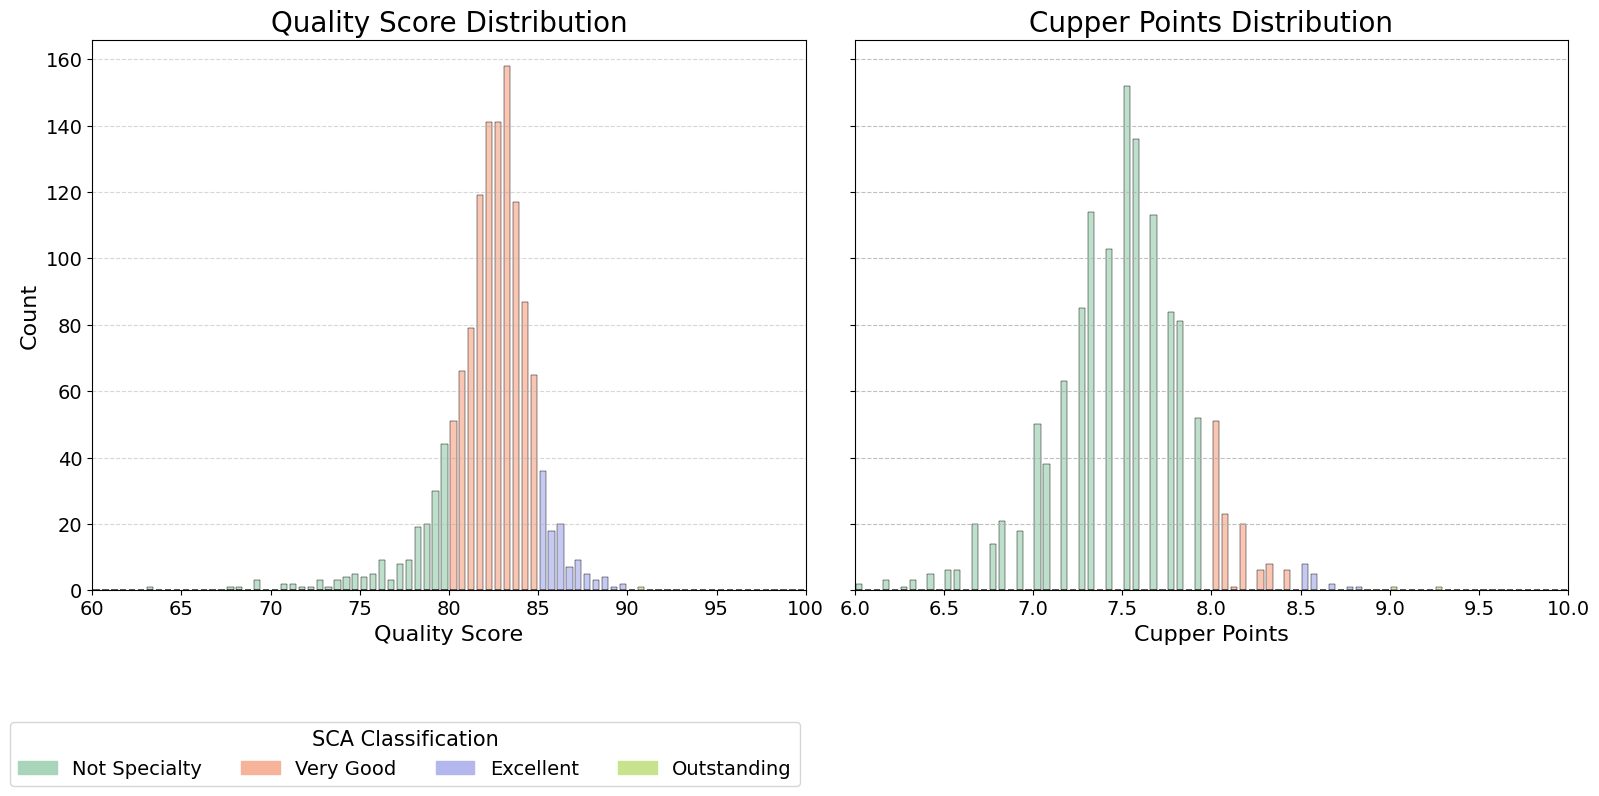

In [113]:
import matplotlib.patches as mpatches

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Adjust bin sizes
quality_bins = np.arange(60, 101, 0.5)       # Wider bins for clarity
cupper_bins = np.arange(6, 10.1, 0.05)      # Wider bins for clarity

# Plot histogram for Quality Score
for category in category_order:
    subset = df_cleaned[df_cleaned['SCA Category'] == category]
    sns.histplot(
        data=subset,
        x='quality_score',
        bins=quality_bins,
        color=category_palette[category],
        edgecolor='black',
        label=category,
        element='bars',
        shrink=0.7,
        ax=axes[0]
    )

axes[0].set_title('Quality Score Distribution', fontsize=20)
axes[0].set_xlabel('Quality Score', fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)
axes[0].set_xlim(60, 100)
axes[0].tick_params(labelsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Plot histogram for Cupper Points
for category in category_order:
    subset = df_cleaned[df_cleaned['Cupper Category'] == category]
    sns.histplot(
        data=subset,
        x='Cupper Points',
        bins=cupper_bins,
        color=category_palette[category],
        edgecolor='black',
        label=category,
        element='bars',
        shrink=0.7,
        ax=axes[1]
    )

axes[1].set_title('Cupper Points Distribution', fontsize=20)
axes[1].set_xlabel('Cupper Points', fontsize=16)
axes[1].set_xlim(6, 10)
axes[1].tick_params(labelsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.8)

# Create custom legend
custom_legend = [
    mpatches.Patch(color=category_palette[label], label=label)
    for label in category_order
]

# Place legend below both plots
fig.legend(
    handles=custom_legend,
    title='SCA Classification',
    loc='upper center',
    bbox_to_anchor=(0.25, -0.025),
    ncol=4,
    fontsize=14,
    title_fontsize=15
)

# Leave space for legend
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

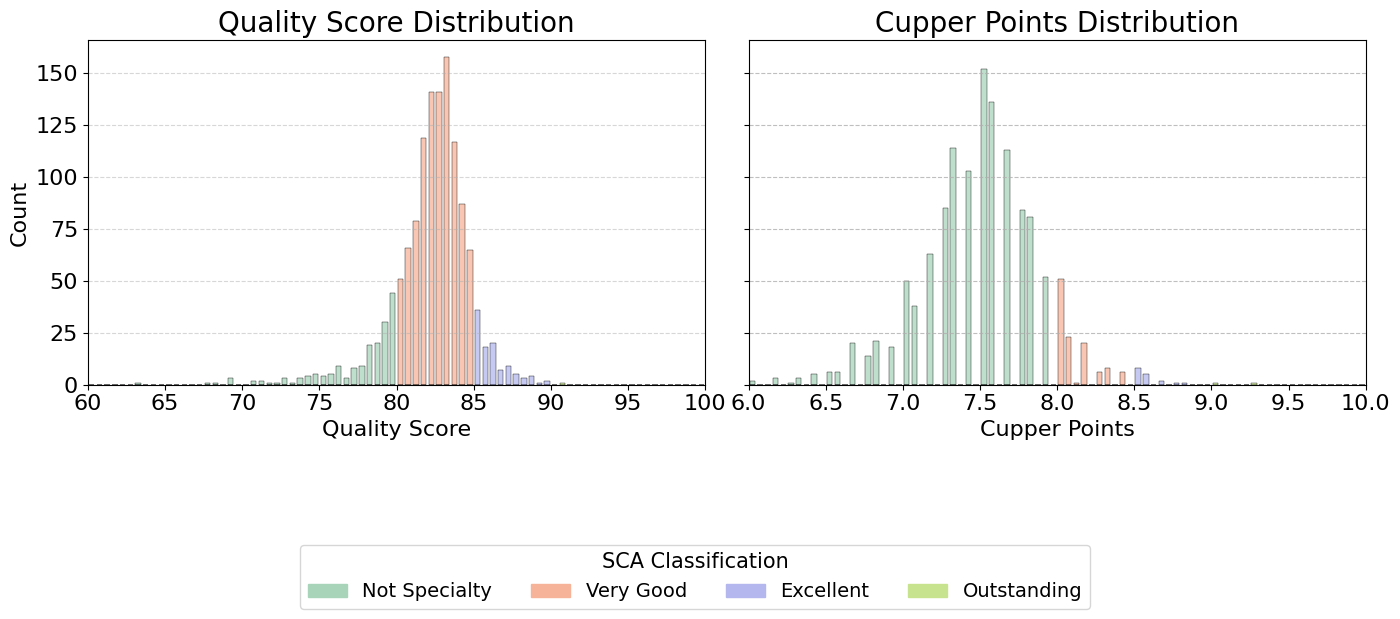

In [114]:
import matplotlib.patches as mpatches

# Smaller height, larger ticks
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Bin sizes
quality_bins = np.arange(60, 101, 0.5)
cupper_bins = np.arange(6, 10.1, 0.05)

# Plot: Quality Score
for category in category_order:
    subset = df_cleaned[df_cleaned['SCA Category'] == category]
    sns.histplot(
        data=subset,
        x='quality_score',
        bins=quality_bins,
        color=category_palette[category],
        edgecolor='black',
        label=category,
        element='bars',
        shrink=0.7,
        ax=axes[0]
    )

axes[0].set_title('Quality Score Distribution', fontsize=20)
axes[0].set_xlabel('Quality Score', fontsize=16)
axes[0].set_ylabel('Count', fontsize=16)
axes[0].set_xlim(60, 100)
axes[0].tick_params(labelsize=16)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Plot: Cupper Points
for category in category_order:
    subset = df_cleaned[df_cleaned['Cupper Category'] == category]
    sns.histplot(
        data=subset,
        x='Cupper Points',
        bins=cupper_bins,
        color=category_palette[category],
        edgecolor='black',
        label=category,
        element='bars',
        shrink=0.7,
        ax=axes[1]
    )

axes[1].set_title('Cupper Points Distribution', fontsize=20)
axes[1].set_xlabel('Cupper Points', fontsize=16)
axes[1].set_xlim(6, 10)
axes[1].tick_params(labelsize=16)
axes[1].grid(axis='y', linestyle='--', alpha=0.8)

# Legend with consistent style
custom_legend = [
    mpatches.Patch(color=category_palette[label], label=label)
    for label in category_order
]

fig.legend(
    handles=custom_legend,
    title='SCA Classification',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=4,
    fontsize=14,
    title_fontsize=15
)

# Adjust layout to leave space for legend
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

In [115]:
# Calculate percentage distribution of Cupper Points categories
cupper_counts = df_cleaned['Cupper Category'].value_counts(normalize=True).sort_index() * 100
display(cupper_counts.round(1))

Cupper Category
Excellent         1.3
Not Specialty    89.5
Outstanding       0.5
Very Good         8.8
Name: proportion, dtype: float64

#### בדיקת התפלגות כל מאפיין סנסורי בנפרד

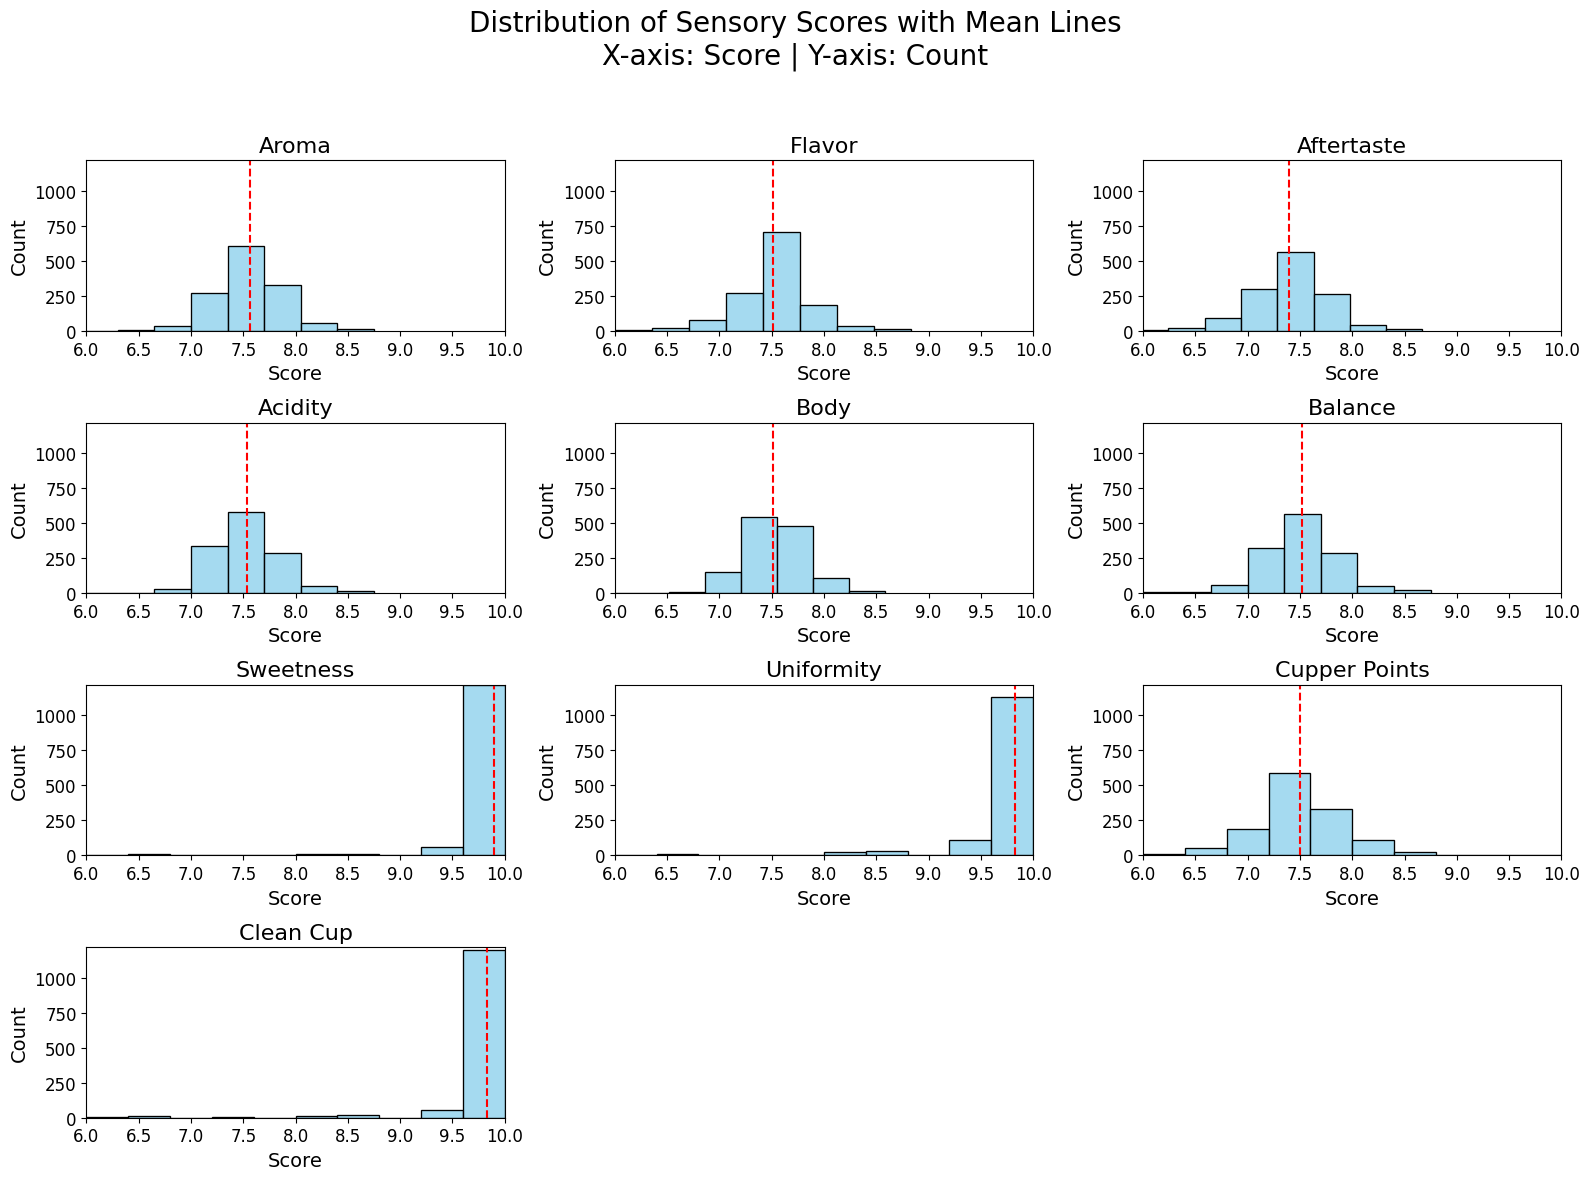

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of sensory features
sensory_features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
                    'Sweetness', 'Uniformity', 'Cupper Points', 'Clean Cup']

# Compute max count across all histograms to unify y-axis scale
max_count = max([
    df_cleaned[feature].value_counts(bins=25).max()
    for feature in sensory_features
])

# Create 4x3 subplot grid
plt.figure(figsize=(16, 12))
for i, feature in enumerate(sensory_features):
    plt.subplot(4, 3, i + 1)

    # Histogram
    sns.histplot(df_cleaned[feature], bins=25, kde=False, color='skyblue', edgecolor='black')

    # Add vertical line for the mean
    plt.axvline(df_cleaned[feature].mean(), color='red', linestyle='--', linewidth=1.5)

    # Formatting
    plt.title(feature, fontsize=16)               # Title size
    plt.xlabel('Score', fontsize=14)              # X label
    plt.ylabel('Count', fontsize=14)              # Y label
    plt.xticks(fontsize=12)                       # X ticks
    plt.yticks(fontsize=12)                       # Y ticks
    plt.xlim(6, 10)
    plt.ylim(0, max_count)

# Global title
plt.suptitle('Distribution of Sensory Scores with Mean Lines\nX-axis: Score | Y-axis: Count',
             fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### קורלציה בין המשתנים הסנסורים



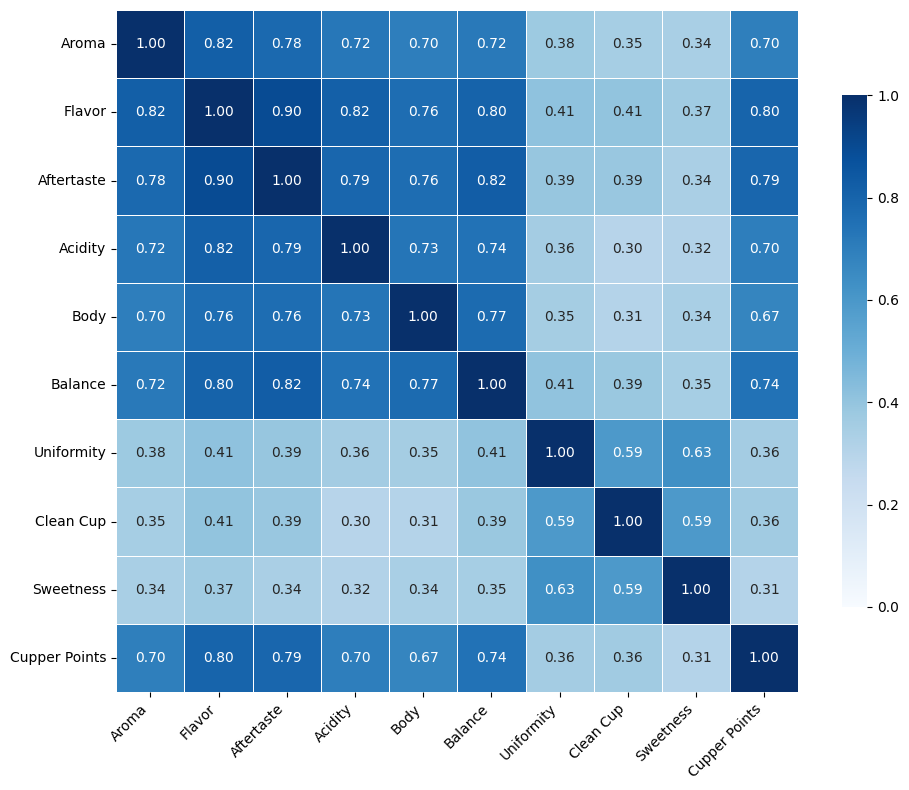

In [117]:
# Select relevant sensory attributes and Cupper Points
sensory_columns = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
    'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points'
]

# Compute correlation matrix
correlation_matrix = df_cleaned[sensory_columns].corr()

# Plot heatmap with uniform color scale (0 to 1)
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",           # Uniform sequential color palette
    vmin=0, vmax=1,         # Color scale range
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

# Title and layout
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### PCA

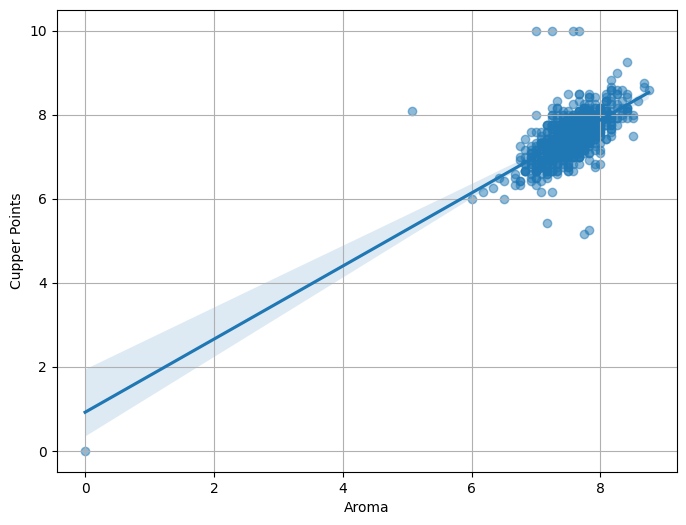

In [118]:
# Scatterplot of Aroma vs. Cupper Points with regression line
plt.figure(figsize=(8, 6))
sns.regplot(data=df, x='Aroma', y='Cupper Points', scatter_kws={'alpha':0.5})
plt.xlabel('Aroma')
plt.ylabel('Cupper Points')
plt.grid(True)
plt.show()

In [119]:
# Import PCA and scaling tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop rows with missing sensory data
df_pca = df_cleaned[sensory_columns].dropna()

# Separate features (excluding Cupper Points)
X = df_pca.drop(columns='Cupper Points')

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA to the scaled data
pca = PCA(n_components=3)
pca.fit(X_scaled)

# Create table: variance explained by each PC
explained_var_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(3)],
    'Explained Variance (%)': (pca.explained_variance_ratio_ * 100).round(2)
})
display(explained_var_df)

# Table: loadings (contribution of each attribute to first 3 PCs)
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(3)]
).round(2)
display(loadings)

Component  Explained Variance (%)
0       PC1                   62.03
1       PC2                   16.88
2       PC3                    4.84

PC1   PC2   PC3
Aroma       0.36 -0.15  0.04
Flavor      0.39 -0.16  0.10
Aftertaste  0.39 -0.17  0.12
Acidity     0.36 -0.21 -0.12
Body        0.36 -0.18 -0.19
Balance     0.37 -0.14  0.05
Uniformity  0.25  0.51 -0.35
Clean Cup   0.24  0.52  0.78
Sweetness   0.23  0.55 -0.44

/tmp/ipython-input-2032123651.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=melted, x='Attribute', y='Score', inner='box', palette='Set2')


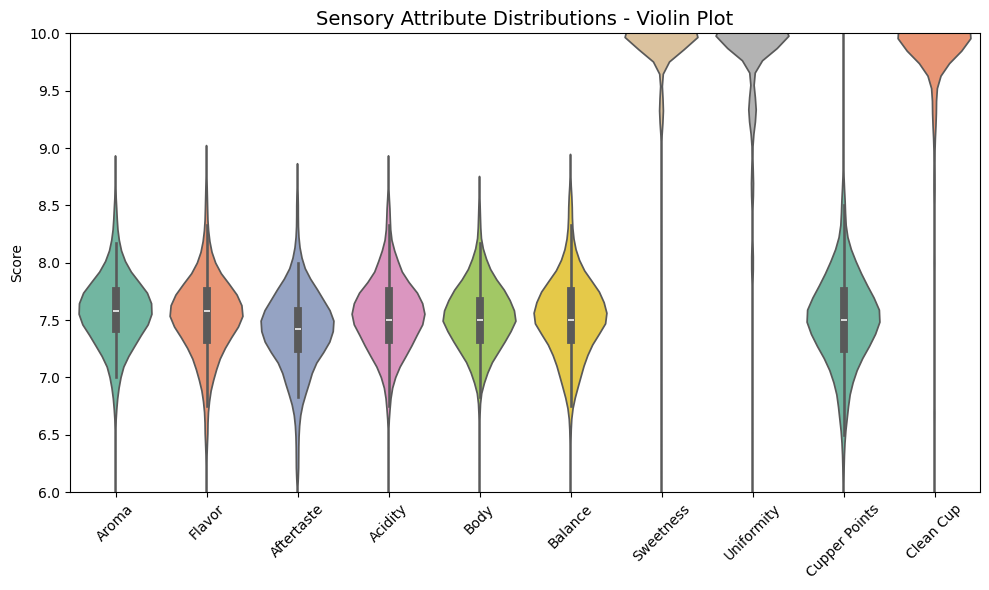

In [120]:
sensory = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
    'Balance', 'Sweetness', 'Uniformity','Cupper Points', 'Clean Cup'
]

data = df_cleaned[sensory].apply(pd.to_numeric, errors='coerce')
melted = data.melt(var_name='Attribute', value_name='Score')

plt.figure(figsize=(10, 6))
sns.violinplot(data=melted, x='Attribute', y='Score', inner='box', palette='Set2')
plt.ylim(6, 10)
plt.title('Sensory Attribute Distributions - Violin Plot', fontsize=14)
plt.ylabel('Score')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## פרטים טכניים

### הסתכלות לפי מדינה

#### התפלגות מדינות

/tmp/ipython-input-3801849374.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.values, y=country_counts.index, palette='viridis')


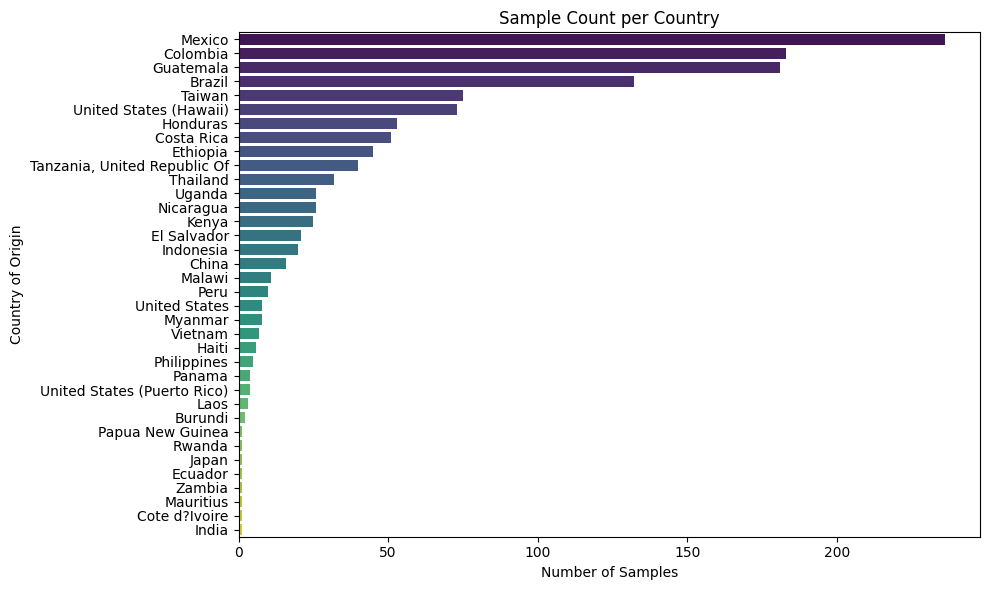

In [121]:
country_counts = df_cleaned['Country of Origin'].value_counts(dropna=False).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=country_counts.values, y=country_counts.index, palette='viridis')
plt.xlabel('Number of Samples')
plt.ylabel('Country of Origin')
plt.title('Sample Count per Country')
plt.tight_layout()
plt.show()

In [122]:
# Count number of unique countries
df_cleaned['Country of Origin'].nunique()

36

In [123]:
# Count number of samples per country
country_counts = df_cleaned['Country of Origin'].value_counts()

# Keep only countries with more than 30 samples
countries_over_30 = country_counts[country_counts > 30].index

# Filter the dataframe to include only those countries
df_cleaned_over_30 = df_cleaned[df_cleaned['Country of Origin'].isin(countries_over_30)]

# Print summary
print(f"Number of samples in df_cleaned_over_30: {df_cleaned_over_30.shape[0]}")
print(df_cleaned_over_30['Country of Origin'].value_counts())

Number of samples in df_cleaned_over_30: 1101
Country of Origin
Mexico                          236
Colombia                        183
Guatemala                       181
Brazil                          132
Taiwan                           75
United States (Hawaii)           73
Honduras                         53
Costa Rica                       51
Ethiopia                         45
Tanzania, United Republic Of     40
Thailand                         32
Name: count, dtype: int64


In [124]:
print(df_cleaned_over_30.columns.tolist())

['Unnamed: 0', 'quality_score', 'Owner', 'Country of Origin', 'Farm Name', 'ICO Number', 'Company', 'Region', 'Producer', 'Harvest Year', 'Grading Date', 'Variety', 'Processing Method', 'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points', 'Total Cup Points', 'Color', 'Expiration', 'Altitude (m)', 'Moisture (%)', 'SCA Category', 'Cupper Category']


/tmp/ipython-input-2965130599.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top11, x='Country (Cleaned)', y='Cupper Points', palette='pastel')


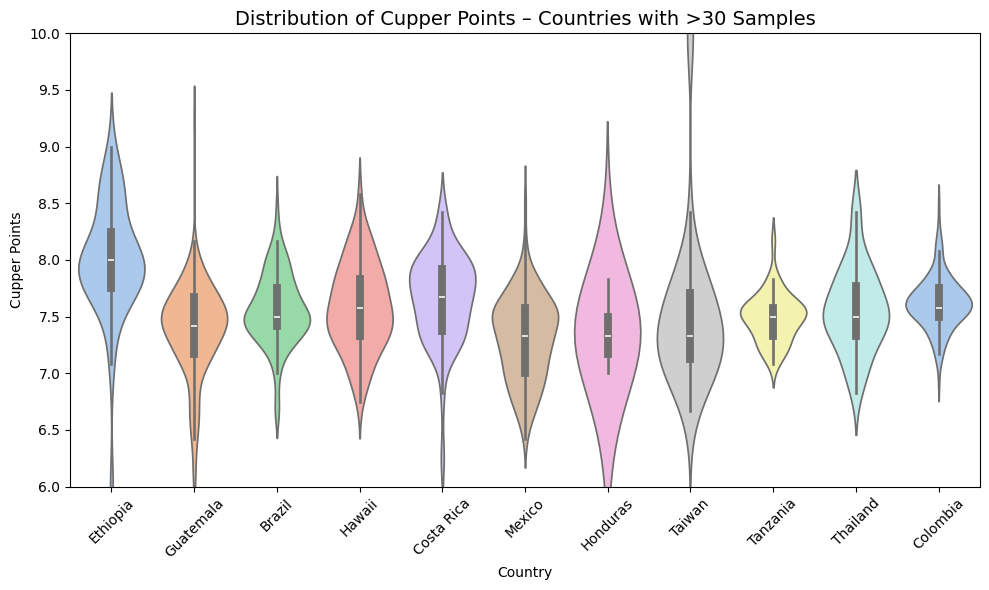

In [125]:
# Count number of samples per country
country_counts = df_cleaned['Country of Origin'].value_counts()

# Get countries with more than 30 samples
countries_over_30 = country_counts[country_counts > 30].index

# Filter the dataframe to include only those countries
df_top11 = df_cleaned[df_cleaned['Country of Origin'].isin(countries_over_30)].copy()

# Simplify country names for readability
df_top11['Country (Cleaned)'] = df_top11['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_top11, x='Country (Cleaned)', y='Cupper Points', palette='pastel')

# Customize plot
plt.title('Distribution of Cupper Points – Countries with >30 Samples', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Cupper Points')
plt.ylim(6, 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

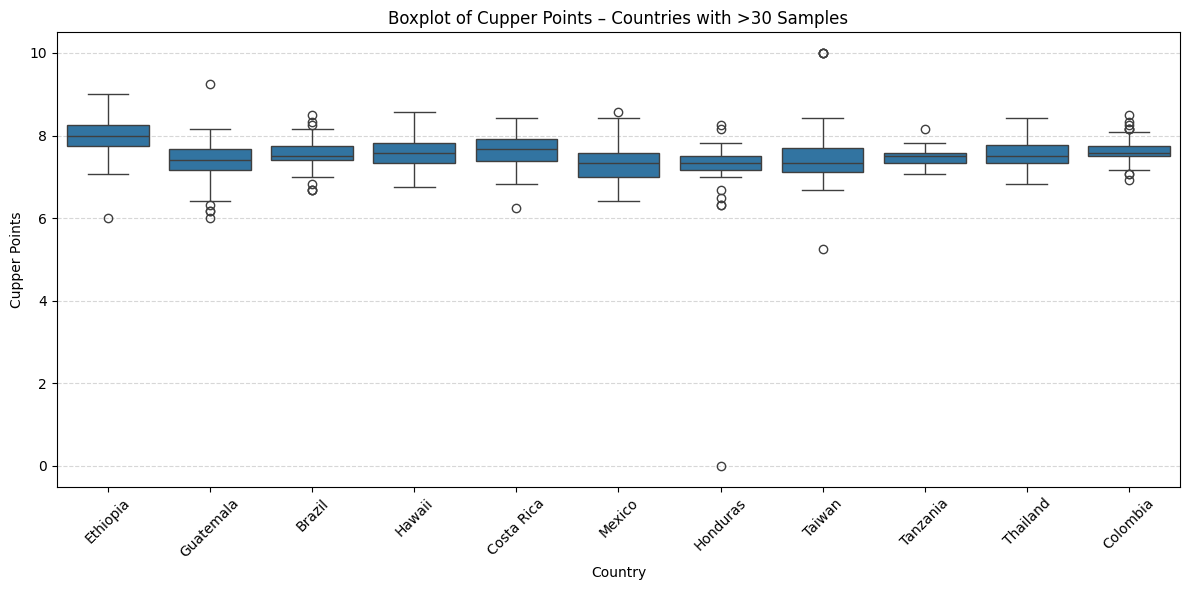

In [126]:
# Filter countries with at least 30 samples
top_countries = df_cleaned['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Filter the dataframe
df_top_countries = df_cleaned[df_cleaned['Country of Origin'].isin(top_countries)].copy()

# Clean country names for better readability
df_top_countries['Country (Cleaned)'] = df_top_countries['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_countries, x='Country (Cleaned)', y='Cupper Points')
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Cupper Points')
plt.title('Boxplot of Cupper Points – Countries with >30 Samples')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1932241971.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=df_top_countries, x='Country (Cleaned)', y='Cupper Points', palette='pastel', size=4)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 45.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 40.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/

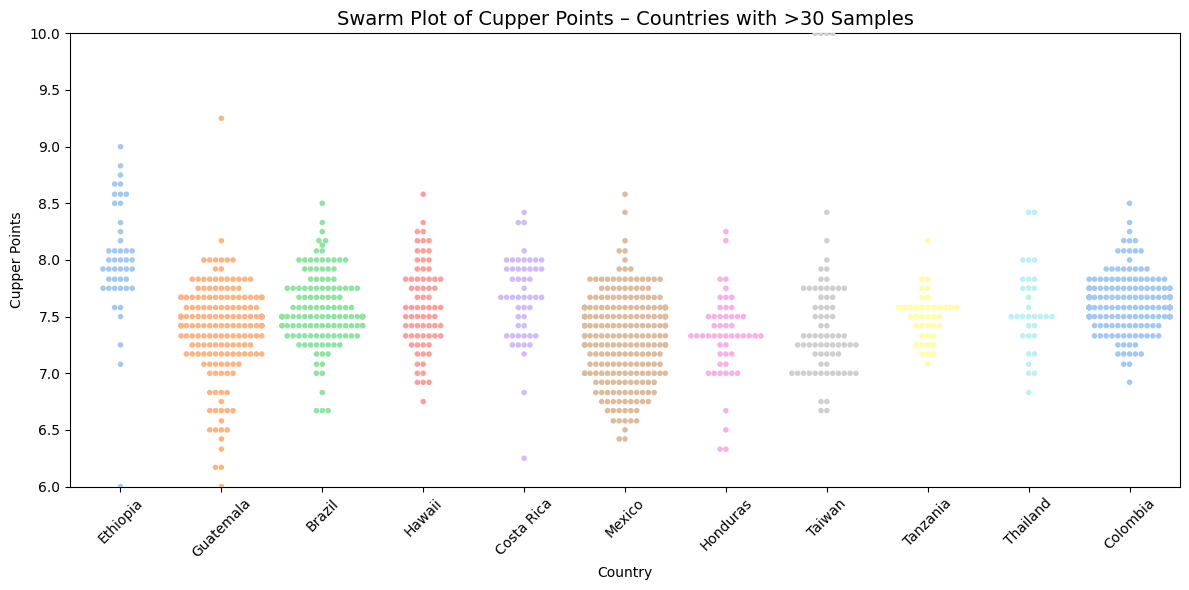

In [127]:
# Filter countries with at least 30 samples
top_countries = df_cleaned['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Filter the dataframe
df_top_countries = df_cleaned[df_cleaned['Country of Origin'].isin(top_countries)].copy()

# Clean country names for readability
df_top_countries['Country (Cleaned)'] = df_top_countries['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})

# Create swarm plot
plt.figure(figsize=(12, 6))
sns.swarmplot(data=df_top_countries, x='Country (Cleaned)', y='Cupper Points', palette='pastel', size=4)

# Customize plot
plt.title('Swarm Plot of Cupper Points – Countries with >30 Samples', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Cupper Points')
plt.ylim(6, 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2706006019.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 40.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 43.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the point

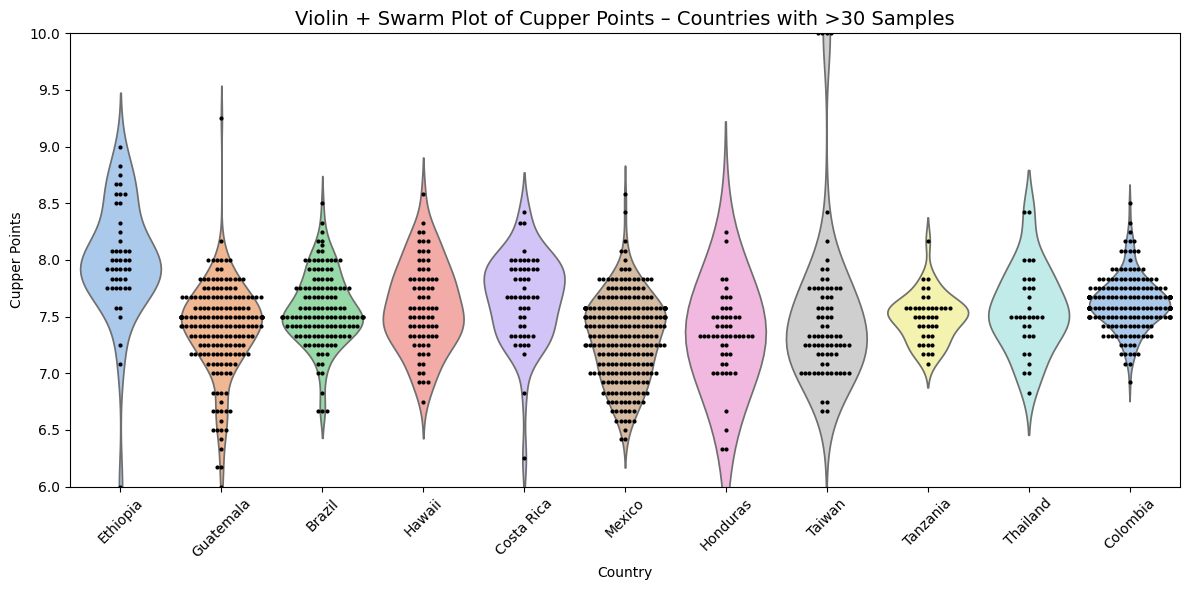

In [128]:
# Filter countries with at least 30 samples
top_countries = df_cleaned['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Filter the dataframe
df_top_countries = df_cleaned[df_cleaned['Country of Origin'].isin(top_countries)].copy()

# Clean country names
df_top_countries['Country (Cleaned)'] = df_top_countries['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})

# Create the plot
plt.figure(figsize=(12, 6))

# Violin plot without inner boxplot
sns.violinplot(
    data=df_top_countries,
    x='Country (Cleaned)',
    y='Cupper Points',
    inner=None,
    palette='pastel'
)

# Swarm plot on top
sns.swarmplot(
    data=df_top_countries,
    x='Country (Cleaned)',
    y='Cupper Points',
    color='k',
    size=3
)

# Customize
plt.title('Violin + Swarm Plot of Cupper Points – Countries with >30 Samples', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Cupper Points')
plt.ylim(6, 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-944170644.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the points ca

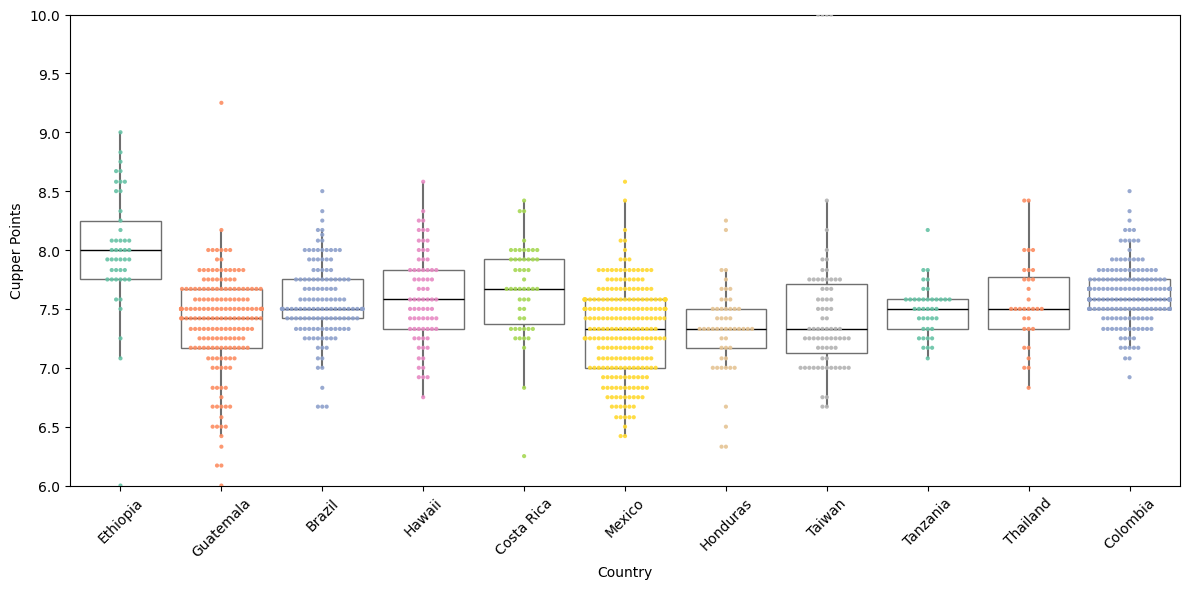

In [129]:
# Filter countries with at least 30 samples
top_countries = df_cleaned['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Filter the dataframe
df_top_countries = df_cleaned[df_cleaned['Country of Origin'].isin(top_countries)].copy()

# Clean country names
df_top_countries['Country (Cleaned)'] = df_top_countries['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii'
})

# Create the plot
plt.figure(figsize=(12, 6))

# Boxplot with transparent fill and no fliers
sns.boxplot(
    data=df_top_countries,
    x='Country (Cleaned)',
    y='Cupper Points',
    showcaps=False,
    boxprops={'facecolor': 'None'},
    showfliers=False,
    whiskerprops={'linewidth': 1.5},
    medianprops={'color': 'black'},
    palette='pastel'
)

# Swarm plot with colored points by country
sns.swarmplot(
    data=df_top_countries,
    x='Country (Cleaned)',
    y='Cupper Points',
    hue='Country (Cleaned)',       # color by country
    dodge=False,
    size=3,
    alpha=0.9,
    palette='Set2'                 # you can choose any palette you like
)

# Customize
plt.xlabel('Country')
plt.ylabel('Cupper Points')
plt.ylim(6, 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [130]:
cv_by_country = (
    df_top_countries.groupby('Country (Cleaned)')['Cupper Points']
    .agg(lambda x: x.std() / x.mean())
    .sort_values(ascending=False)
)
print(cv_by_country)

Country (Cleaned)
Honduras      0.149000
Taiwan        0.098435
Ethiopia      0.063688
Guatemala     0.055031
Mexico        0.051447
Costa Rica    0.050493
Hawaii        0.050309
Thailand      0.049386
Brazil        0.042198
Colombia      0.030839
Tanzania      0.028590
Name: Cupper Points, dtype: float64


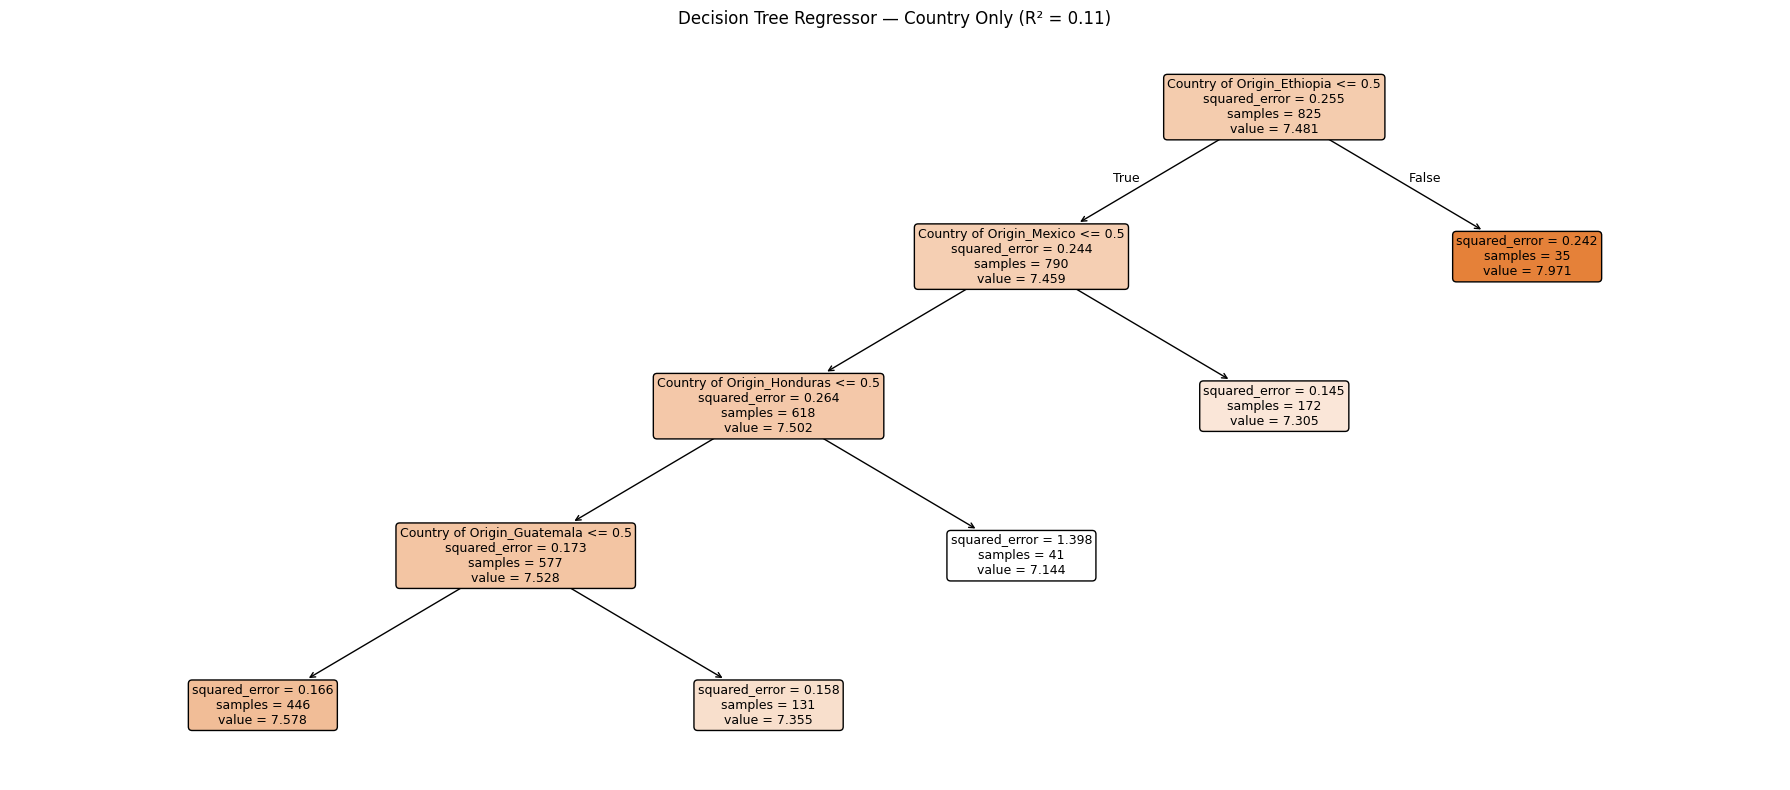

In [131]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Filter for countries with at least 30 samples
top_countries = df['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Filter the dataset
df_country = df[df['Country of Origin'].isin(top_countries)].copy()
df_country['Country of Origin'] = df_country['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})
df_country['Cupper Points'] = pd.to_numeric(df_country['Cupper Points'], errors='coerce')
df_country = df_country.dropna(subset=['Cupper Points', 'Country of Origin'])

# One-hot encode countries
X = pd.get_dummies(df_country[['Country of Origin']], drop_first=True)
y = df_country['Cupper Points']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the tree
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Predict and evaluate
y_pred = tree.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Plot
plt.figure(figsize=(18, 8))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, fontsize=9)
plt.title(f'Decision Tree Regressor — Country Only (R² = {r2:.2f})')
plt.tight_layout()
plt.show()


#### השוואת אחוזי לחות וגובה בין המדינות השונות

<Figure size 1200x600 with 0 Axes>

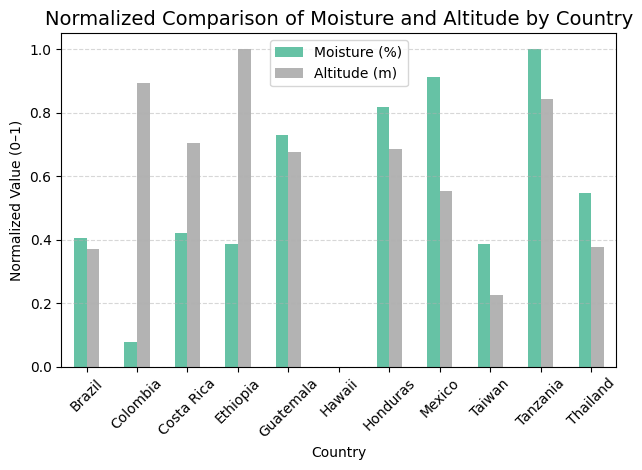

In [132]:
# Clean country names first
df_top_countries['Country (Cleaned)'] = df_top_countries['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})

# Calculate average values per cleaned country
mean_values = df_top_countries.groupby('Country (Cleaned)')[['Moisture (%)', 'Altitude (m)']].mean()

# Normalize each column using min-max normalization
normalized = (mean_values - mean_values.min()) / (mean_values.max() - mean_values.min())

# Plot normalized values
plt.figure(figsize=(12, 6))
normalized.plot(kind='bar', colormap='Set2')
plt.title('Normalized Comparison of Moisture and Altitude by Country', fontsize=14)
plt.ylabel('Normalized Value (0–1)')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [133]:
# Filter countries with at least 30 samples
top_countries = df_cleaned['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Filter and clean
df_top_countries = df_cleaned[df_cleaned['Country of Origin'].isin(top_countries)].copy()
df_top_countries['Country (Cleaned)'] = df_top_countries['Country of Origin'].replace({

})

# Aggregate: mean moisture, mean altitude, most common processing method
summary_table = df_top_countries.groupby('Country (Cleaned)').agg({
    'Moisture (%)': 'mean',
    'Altitude (m)': 'mean',
    'Processing Method': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).rename(columns={
    'Moisture (%)': 'Avg Moisture (%)',
    'Altitude (m)': 'Avg Altitude (m)',
    'Processing Method': 'Most Common Processing'
})

# Display the summary table
import pandas as pd
from IPython.display import display
display(summary_table.round(2))

Avg Moisture (%)  Avg Altitude (m)  \
Country (Cleaned)                                                  
Brazil                                    8.23           1049.86   
Colombia                                  6.20           1675.09   
Costa Rica                                8.33           1450.00   
Ethiopia                                  8.11           1800.20   
Guatemala                                10.23           1414.77   
Honduras                                 10.77           1424.45   
Mexico                                   11.36           1269.74   
Taiwan                                    8.11            878.39   
Tanzania, United Republic Of             11.90           1615.08   
Thailand                                  9.09           1059.37   
United States (Hawaii)                    5.73            609.60   

                             Most Common Processing  
Country (Cleaned)                                    
Brazil                                Natural / Dry  
Colombia                               Washed / Wet  
Costa Rica                             Washed / Wet  
Ethiopia                              Natural / Dry  
Guatemala                              Washed / Wet  
Honduras                               Washed / Wet  
Mexico                                 Washed / Wet  
Taiwan                                 Washed / Wet  
Tanzania, United Republic Of           Washed / Wet  
Thailand                               Washed / Wet  
United States (Hawaii)                Natural / Dry

Pearson correlation: 0.33 (p-value: 0.316)


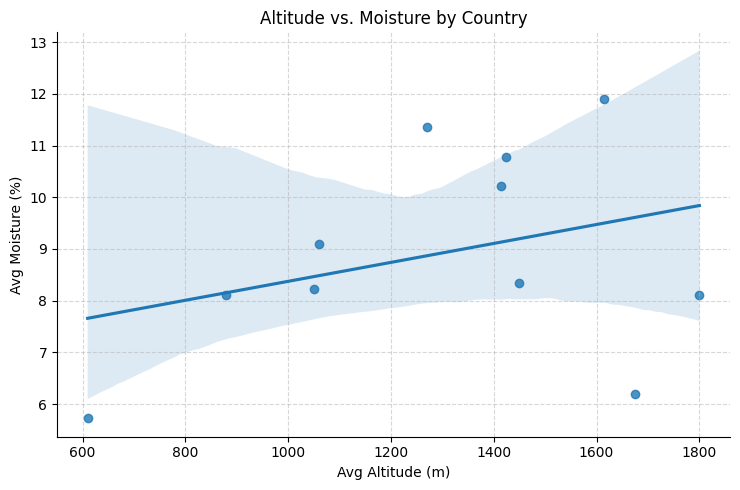

In [134]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter countries with at least 30 samples
top_countries = df_cleaned['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Step 2: Filter dataframe and clean country names
df_top_countries = df_cleaned[df_cleaned['Country of Origin'].isin(top_countries)].copy()
df_top_countries['Country (Cleaned)'] = df_top_countries['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})

# Step 3: Create summary table with averages
summary_table = df_top_countries.groupby('Country (Cleaned)').agg({
    'Moisture (%)': 'mean',
    'Altitude (m)': 'mean',
    'Processing Method': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).rename(columns={
    'Moisture (%)': 'Avg Moisture (%)',
    'Altitude (m)': 'Avg Altitude (m)',
    'Processing Method': 'Most Common Processing'
})

# Step 4: Correlation
df_corr = summary_table.dropna(subset=['Avg Altitude (m)', 'Avg Moisture (%)'])
corr, pval = pearsonr(df_corr['Avg Altitude (m)'], df_corr['Avg Moisture (%)'])
print(f"Pearson correlation: {corr:.2f} (p-value: {pval:.3f})")

# Step 5: Scatter plot with regression line
sns.lmplot(data=df_corr.reset_index(), x='Avg Altitude (m)', y='Avg Moisture (%)', height=5, aspect=1.5)
plt.title('Altitude vs. Moisture by Country')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

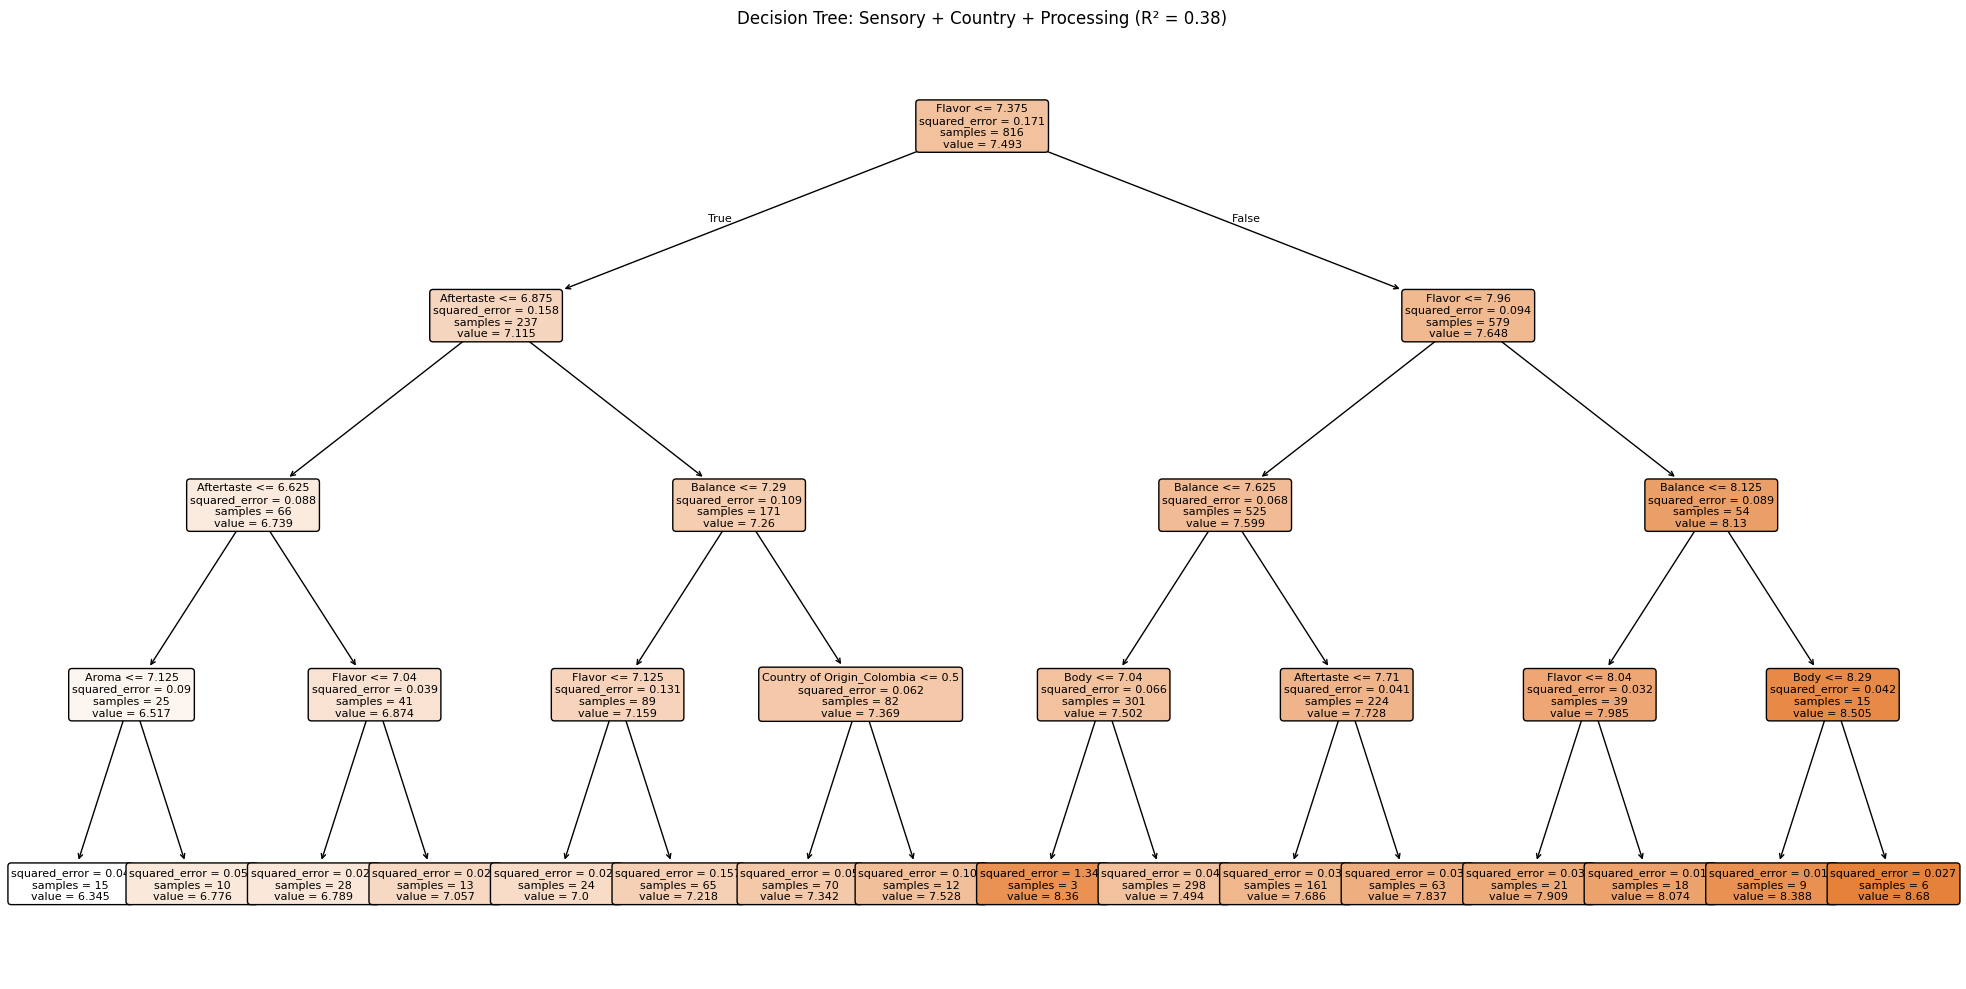

In [135]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Sensory features
sensory_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
                'Balance', 'Uniformity', 'Clean Cup', 'Sweetness']

# Base dataframe with valid countries and methods
top_countries = df['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

df_full = df[df['Country of Origin'].isin(top_countries)].copy()
df_full['Country of Origin'] = df_full['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})
df_full['Processing Method'] = df_full['Processing Method'].astype(str).str.strip().str.title()
df_full = df_full[~df_full['Processing Method'].str.lower().isin(['other'])]

# Convert Cupper Points to numeric
df_full['Cupper Points'] = pd.to_numeric(df_full['Cupper Points'], errors='coerce')

# Drop missing
df_full = df_full.dropna(subset=['Cupper Points'] + sensory_cols)

# One-hot encoding for categorical vars
X = pd.concat([
    df_full[sensory_cols],
    pd.get_dummies(df_full[['Processing Method', 'Country of Origin']], drop_first=True)
], axis=1)

y = df_full['Cupper Points']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit the decision tree
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Predict and score
y_pred = tree.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, fontsize=8)
plt.title(f'Decision Tree: Sensory + Country + Processing (R² = {r2:.2f})')
plt.tight_layout()
plt.show()

### התפלגות שיטת עיבוד

In [136]:
# Count unique processing methods (excluding NaN)
num_methods = df['Processing Method'].dropna().str.strip().nunique()

print(f"Number of unique processing methods (excluding NaN): {num_methods}")

Number of unique processing methods (excluding NaN): 5


In [137]:
# Count unique processing methods, excluding NaN and 'Other'
filtered_methods = df['Processing Method'].dropna().str.strip()
filtered_methods = filtered_methods[~filtered_methods.str.lower().isin(['other'])]

num_methods = filtered_methods.nunique()
print(f"Number of unique processing methods (excluding NaN and 'Other'): {num_methods}")

Number of unique processing methods (excluding NaN and 'Other'): 4


/tmp/ipython-input-3794209856.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_proc, x='Processing Method', y='Altitude (m)', palette='Set2')


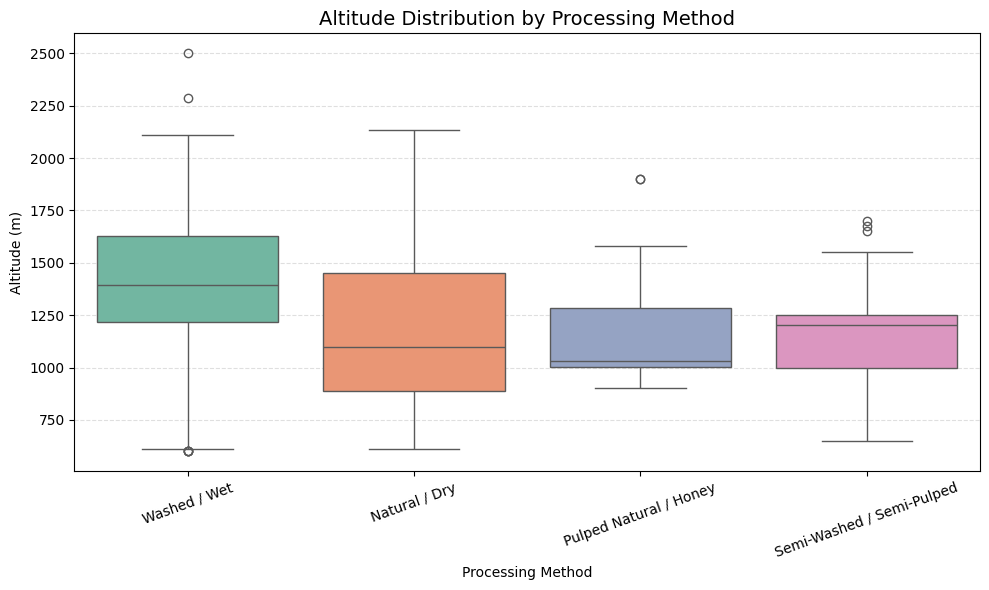

In [138]:
# Clean categories: remove NaNs and 'Other', unify text format
df_proc = df_cleaned.dropna(subset=['Processing Method', 'Altitude (m)']).copy()
df_proc['Processing Method'] = df_proc['Processing Method'].str.strip().str.title()
df_proc = df_proc[~df_proc['Processing Method'].str.lower().isin(['other'])]

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_proc, x='Processing Method', y='Altitude (m)', palette='Set2')

# Customize
plt.title('Altitude Distribution by Processing Method', fontsize=14)
plt.xlabel('Processing Method')
plt.ylabel('Altitude (m)')
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

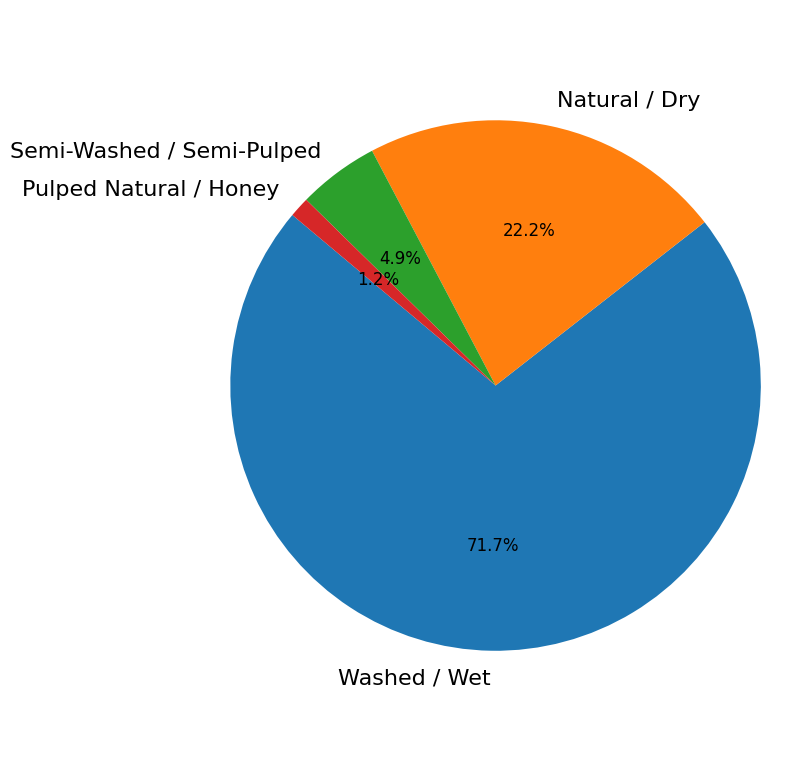

In [139]:
# Remove NaN and 'Other' from 'Processing Method'
df_clean = df[df['Processing Method'].notna()].copy()
df_clean['Processing Method'] = df_clean['Processing Method'].str.strip().str.title()
df_clean = df_clean[~df_clean['Processing Method'].str.lower().isin(['other'])]

# Count how many samples per processing method
processing_counts = df_clean['Processing Method'].value_counts()

# Plot pie chart with larger label text
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    processing_counts,
    labels=processing_counts.index,
    autopct='%1.1f%%',
    startangle=140
)

# Set font size for method labels (the labels around the pie)
for text in texts:
    text.set_fontsize(16)

# Optional: Set font size for percentage labels inside the pie
for autotext in autotexts:
    autotext.set_fontsize(12)

# Title
plt.axis('equal')
plt.tight_layout()
plt.show()


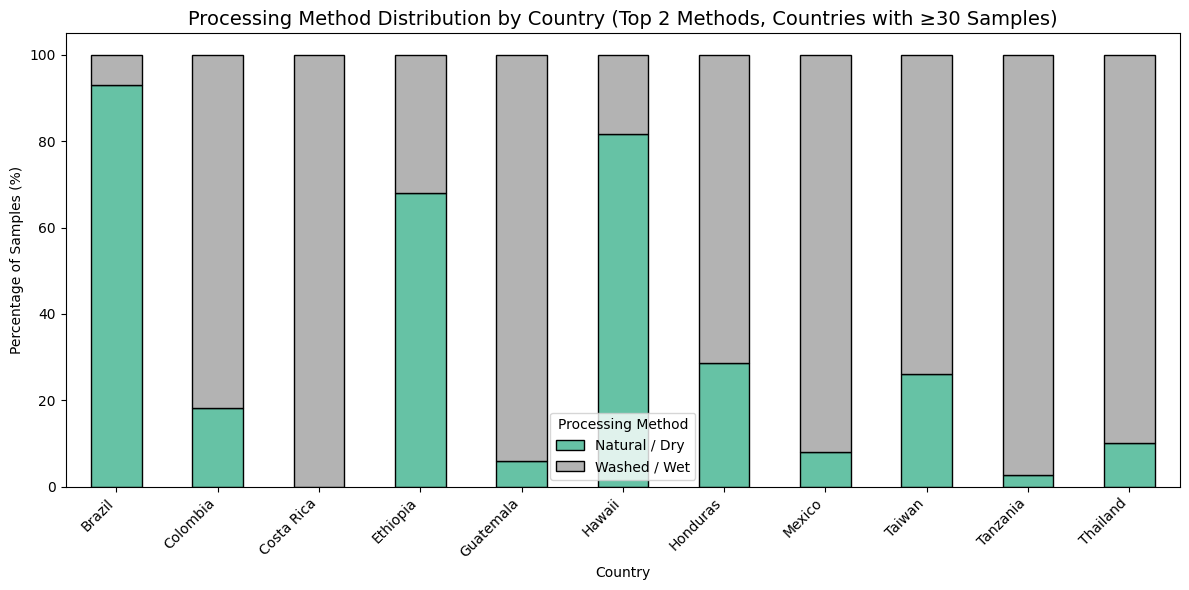

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

# Select countries with at least 30 samples
top_countries = df['Country of Origin'].value_counts()
top_countries = top_countries[top_countries >= 30].index

# Select top 2 processing methods
top_methods = df['Processing Method'].value_counts().nlargest(2).index.tolist()

# Filter data by top countries and top processing methods
df_top = df[df['Country of Origin'].isin(top_countries) & df['Processing Method'].isin(top_methods)].copy()
df_top['Processing Method'] = df_top['Processing Method'].astype(str).str.strip()

# Replace long country names with shorter versions
df_top['Country of Origin'] = df_top['Country of Origin'].replace({
    'Tanzania, United Republic Of': 'Tanzania',
    'United States (Hawaii)': 'Hawaii',
    'United States (Puerto Rico)': 'Puerto Rico'
})

# Create crosstab (country × method)
cross_tab = pd.crosstab(df_top['Country of Origin'], df_top['Processing Method'])

# Normalize by row (percentage)
cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100

# Plot
cross_tab_percent.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2', edgecolor='black')
plt.title('Processing Method Distribution by Country (Top 2 Methods, Countries with ≥30 Samples)', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Percentage of Samples (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Processing Method')
plt.tight_layout()
plt.show()


/tmp/ipython-input-3389160203.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_cup, x='Processing Method', y='Cupper Points', jitter=True, alpha=0.5, palette='Set2')


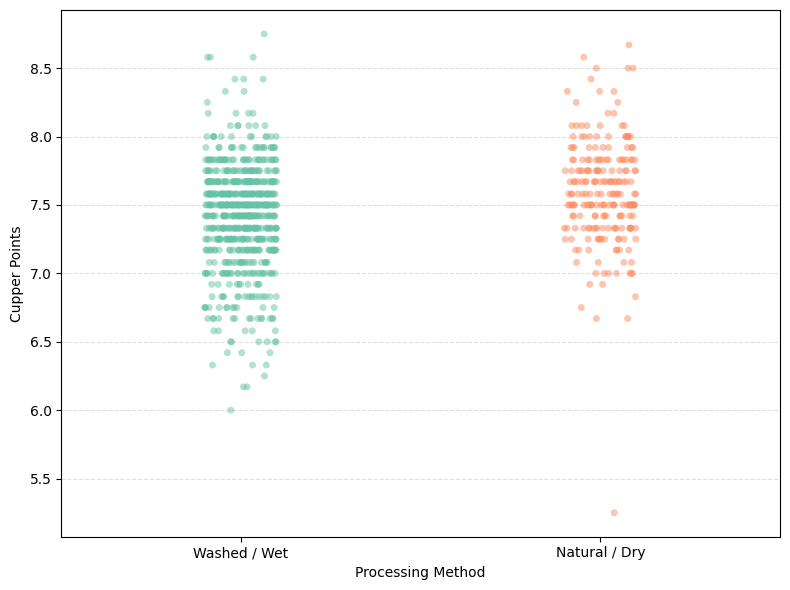

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for top countries and top 2 methods
df_cup = df[df['Country of Origin'].isin(top_countries) & df['Processing Method'].isin(top_methods)].copy()
df_cup['Cupper Points'] = pd.to_numeric(df_cup['Cupper Points'], errors='coerce')
df_cup = df_cup.dropna(subset=['Cupper Points'])

# Plot stripplot of Cupper Points
plt.figure(figsize=(8, 6))
sns.stripplot(data=df_cup, x='Processing Method', y='Cupper Points', jitter=True, alpha=0.5, palette='Set2')

plt.xlabel('Processing Method')
plt.ylabel('Cupper Points')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

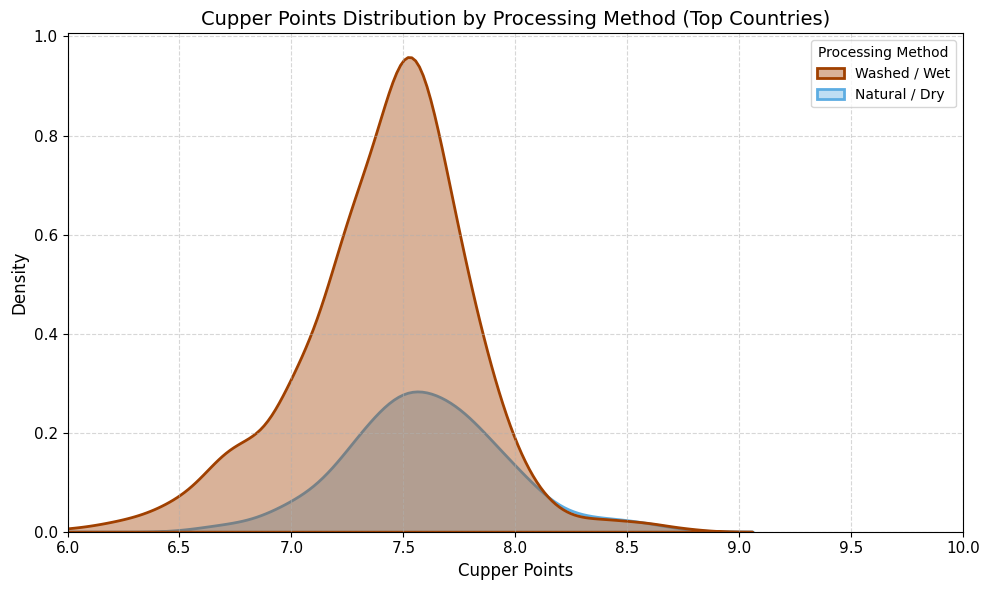

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define reversed color palette
custom_palette = {
    'Natural / Dry': '#5DADE2',   # light blue
    'Washed / Wet': '#A04000'     # brown
}

# Filter for top countries and top 2 methods
df_kde = df[df['Country of Origin'].isin(top_countries) & df['Processing Method'].isin(top_methods)].copy()
df_kde['Cupper Points'] = pd.to_numeric(df_kde['Cupper Points'], errors='coerce')
df_kde = df_kde.dropna(subset=['Cupper Points'])

# Plot KDE with custom color order
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_kde,
    x='Cupper Points',
    hue='Processing Method',
    fill=True,
    alpha=0.4,
    linewidth=2,
    palette=custom_palette
)

plt.title('Cupper Points Distribution by Processing Method (Top Countries)', fontsize=14)
plt.xlabel('Cupper Points', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(6, 10)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

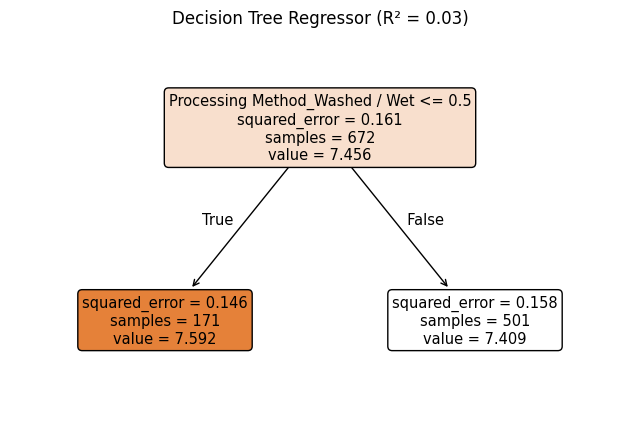

In [143]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Filter for top countries and top 2 processing methods
df_tree = df[df['Country of Origin'].isin(top_countries) & df['Processing Method'].isin(top_methods)].copy()
df_tree['Processing Method'] = df_tree['Processing Method'].astype(str).str.strip()
df_tree['Cupper Points'] = pd.to_numeric(df_tree['Cupper Points'], errors='coerce')
df_tree = df_tree.dropna(subset=['Cupper Points'])

# Encode Processing Method as dummy variable (one-hot encoding)
X = pd.get_dummies(df_tree[['Processing Method']], drop_first=True)
y = df_tree['Cupper Points']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit decision tree
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# Predict and evaluate
y_pred = tree.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Plot the tree
plt.figure(figsize=(8, 5))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True)
plt.title(f'Decision Tree Regressor (R² = {r2:.2f})')
plt.show()

In [144]:
# Filter only the two main methods
methods = ['Washed / Wet', 'Natural / Dry']
df_comp = df[df['Processing Method'].isin(methods)].copy()
df_comp['Processing Method'] = df_comp['Processing Method'].str.strip().str.title()
df_comp['Cupper Points'] = pd.to_numeric(df_comp['Cupper Points'], errors='coerce')
df_comp = df_comp.dropna(subset=['Cupper Points'])

# Group statistics
group_stats = df_comp.groupby('Processing Method')['Cupper Points'].agg(['count', 'mean', 'std'])
display(group_stats)

count      mean       std
Processing Method                           
Natural / Dry        251  7.578327  0.390465
Washed / Wet         812  7.442906  0.388373

/tmp/ipython-input-1617560484.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='Processing Method', y='mean', palette=method_palette, order=method_order, capsize=0.2)


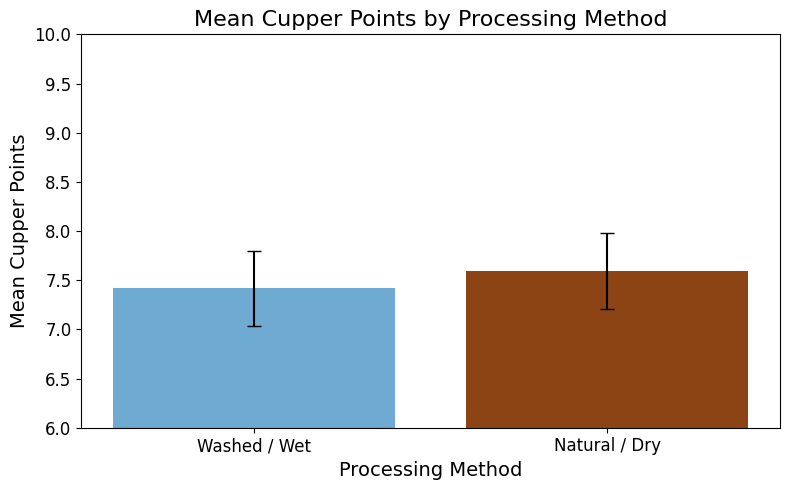

/tmp/ipython-input-1617560484.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_methods, x='Processing Method', y='Cupper Points', palette=method_palette, order=method_order)


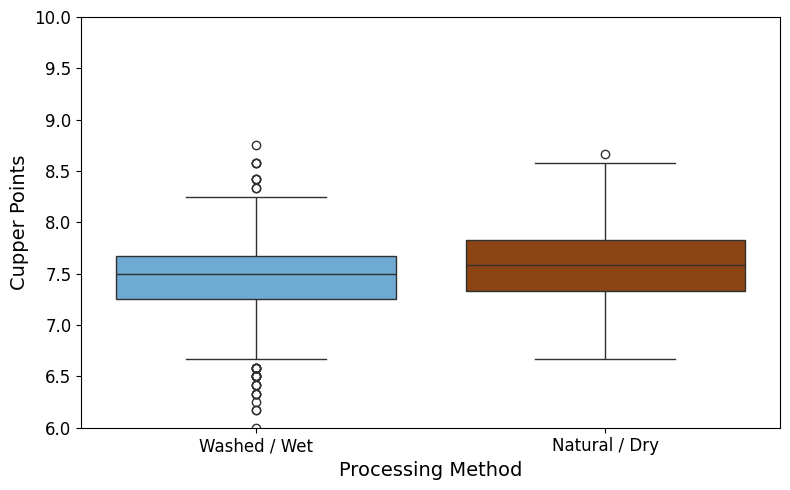

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define order and colors
method_order = ['Washed / Wet', 'Natural / Dry']
method_palette = {'Washed / Wet': '#5DADE2', 'Natural / Dry': '#A04000'}  # light blue, brown

# Get top methods (make sure they match desired order)
df_top_methods = df_top_countries[df_top_countries['Processing Method'].isin(method_order)]

# Compute mean and std
summary = df_top_methods.groupby('Processing Method')['Cupper Points'].agg(['mean', 'std']).reindex(method_order).reset_index()

# Plot mean with error bars
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x='Processing Method', y='mean', palette=method_palette, order=method_order, capsize=0.2)

# Add standard deviation bars manually
for i, row in summary.iterrows():
    plt.errorbar(x=i, y=row['mean'], yerr=row['std'], fmt='none', color='black', capsize=5)

plt.title('Mean Cupper Points by Processing Method', fontsize=16)
plt.ylabel('Mean Cupper Points', fontsize=14)
plt.xlabel('Processing Method', fontsize=14)
plt.ylim(6, 10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plot full distribution (boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_top_methods, x='Processing Method', y='Cupper Points', palette=method_palette, order=method_order)

plt.ylabel('Cupper Points', fontsize=14)
plt.xlabel('Processing Method', fontsize=14)
plt.ylim(6, 10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### השפעה על הציון הסובייקטיבי

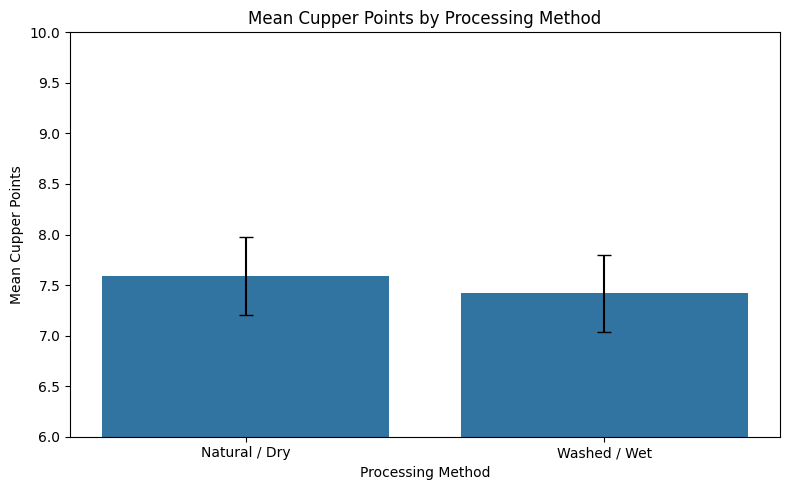

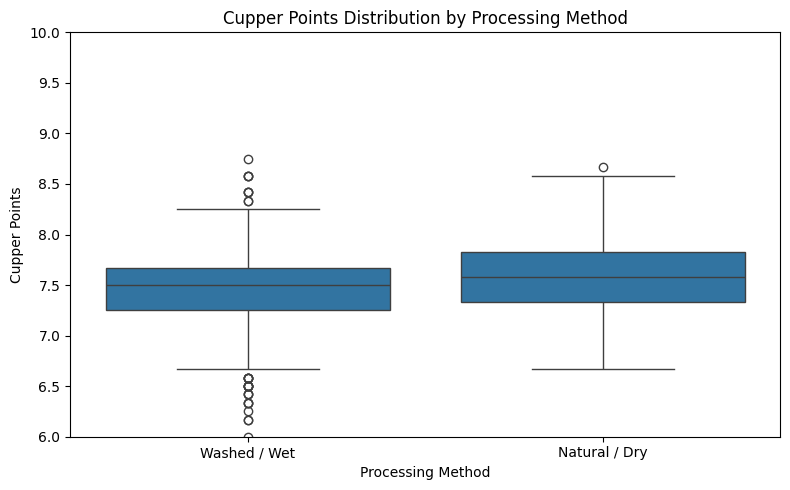

In [146]:
# Step 1 – Mean and Distribution of Cupper Points by Top 2 Processing Methods

import matplotlib.pyplot as plt
import seaborn as sns

# Get the two most common processing methods
method_counts = df_top_countries['Processing Method'].value_counts()
top_methods = method_counts.nlargest(2).index.tolist()

# Filter the dataframe
df_top_methods = df_top_countries[df_top_countries['Processing Method'].isin(top_methods)]

# Compute group means and standard deviations
summary = df_top_methods.groupby('Processing Method')['Cupper Points'].agg(['mean', 'std']).reset_index()

# Plot mean Cupper Points with error bars
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x='Processing Method', y='mean', capsize=0.2)
for i, row in summary.iterrows():
    plt.errorbar(x=i, y=row['mean'], yerr=row['std'], fmt='none', color='black', capsize=5)
plt.title('Mean Cupper Points by Processing Method')
plt.ylabel('Mean Cupper Points')
plt.xlabel('Processing Method')
plt.ylim(6, 10)
plt.tight_layout()
plt.show()

# Plot full distribution with boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_top_methods, x='Processing Method', y='Cupper Points')
plt.title('Cupper Points Distribution by Processing Method')
plt.ylabel('Cupper Points')
plt.xlabel('Processing Method')
plt.ylim(6, 10)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3480063606.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_methods, x='Processing Method', y='Cupper Points',


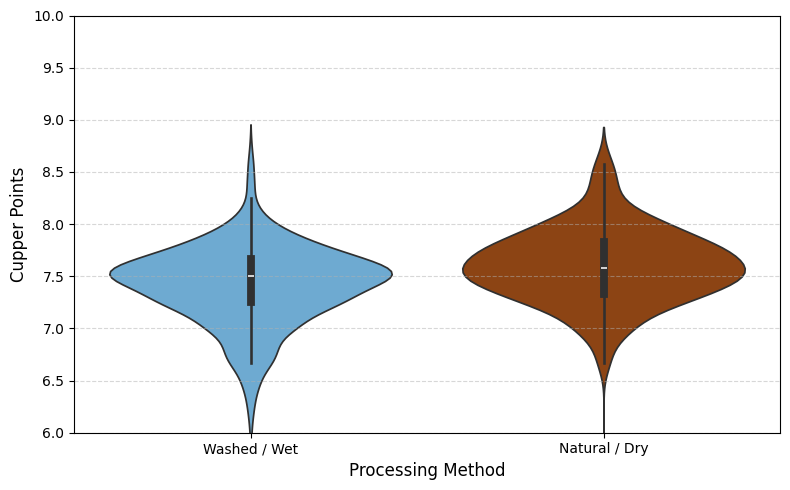

/tmp/ipython-input-3480063606.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_top_methods, x='Processing Method', y='Cupper Points',


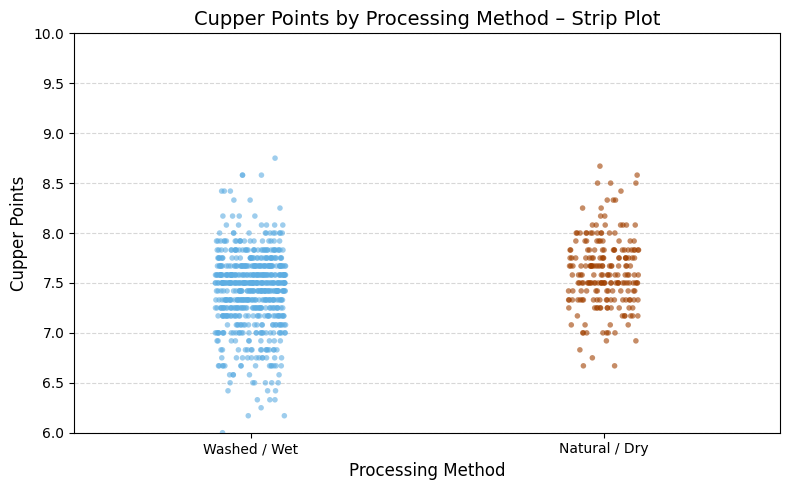

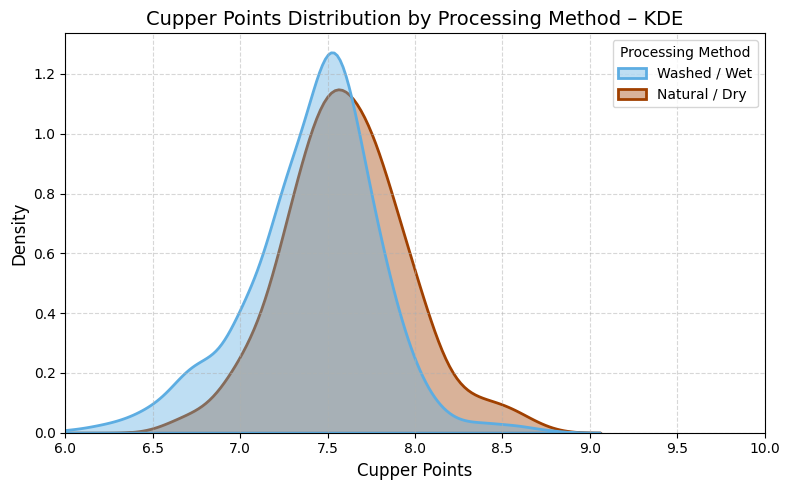

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define fixed order and colors
method_order = ['Washed / Wet', 'Natural / Dry']
method_palette = {'Washed / Wet': '#5DADE2', 'Natural / Dry': '#A04000'}

# --- 1. Violin Plot ---
plt.figure(figsize=(8, 5))
sns.violinplot(data=df_top_methods, x='Processing Method', y='Cupper Points',
               palette=method_palette, order=method_order, inner='box')
plt.xlabel('Processing Method', fontsize=12)
plt.ylabel('Cupper Points', fontsize=12)
plt.ylim(6, 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 2. Strip Plot (each point separately) ---
plt.figure(figsize=(8, 5))
sns.stripplot(data=df_top_methods, x='Processing Method', y='Cupper Points',
              palette=method_palette, order=method_order, jitter=True, alpha=0.6, size=4)
plt.title('Cupper Points by Processing Method – Strip Plot', fontsize=14)
plt.xlabel('Processing Method', fontsize=12)
plt.ylabel('Cupper Points', fontsize=12)
plt.ylim(6, 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 3. KDE Plot ---
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_top_methods, x='Cupper Points', hue='Processing Method',
            palette=method_palette, fill=True, alpha=0.4, linewidth=2, common_norm=False)
plt.title('Cupper Points Distribution by Processing Method – KDE', fontsize=14)
plt.xlabel('Cupper Points', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(6, 10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1142540038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_top_methods, x='Processing Method', y='Cupper Points',


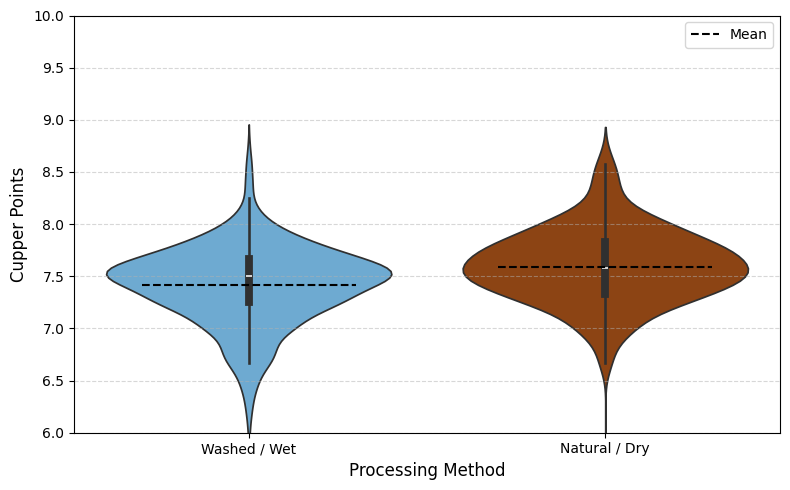

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define fixed order and colors
method_order = ['Washed / Wet', 'Natural / Dry']
method_palette = {'Washed / Wet': '#5DADE2', 'Natural / Dry': '#A04000'}

# --- Violin Plot with Mean Lines ---
plt.figure(figsize=(8, 5))
ax = sns.violinplot(data=df_top_methods, x='Processing Method', y='Cupper Points',
                    palette=method_palette, order=method_order, inner='box')

# Add mean lines manually
for i, method in enumerate(method_order):
    mean_val = df_top_methods[df_top_methods['Processing Method'] == method]['Cupper Points'].mean()
    ax.hlines(mean_val, i - 0.3, i + 0.3, colors='black', linestyles='--', linewidth=1.5, label='Mean' if i == 0 else "")

# Labels and formatting
plt.xlabel('Processing Method', fontsize=12)
plt.ylabel('Cupper Points', fontsize=12)
plt.ylim(6, 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Optional: show legend once
plt.legend(loc='upper right', frameon=True)
plt.tight_layout()
plt.show()

In [149]:
from scipy.stats import ttest_ind

# Define the two processing methods
method1 = top_methods[0]
method2 = top_methods[1]

# Extract Cupper Points for each group
group1 = df_top_methods[df_top_methods['Processing Method'] == method1]['Cupper Points']
group2 = df_top_methods[df_top_methods['Processing Method'] == method2]['Cupper Points']

# Perform independent t-test (Welch's version, unequal variances)
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ Statistically significant difference between processing methods.")
else:
    print("❌ No statistically significant difference found.")

T-statistic: -5.879
P-value: 0.00000
✅ Statistically significant difference between processing methods.


## ניתוח מעמיק

In [150]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Sensory features
sensory_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
                'Balance', 'Uniformity', 'Clean Cup', 'Sweetness']

# Clean data
df_cluster = df[sensory_cols + ['Cupper Points']].dropna().copy()

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[sensory_cols])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Filter outliers (e.g., PC1 < -20)
mask = X_pca[:, 0] > -20
X_filtered = X_scaled[mask]
X_pca_filtered = X_pca[mask]
cupper_filtered = df_cluster['Cupper Points'].values[mask]

# Interactive plot function
def plot_kmeans(k):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_filtered)

    df_plot = pd.DataFrame(X_pca_filtered, columns=['PC1', 'PC2'])
    df_plot['Cluster'] = labels
    df_plot['Cupper Points'] = cupper_filtered

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Cluster',
                    palette='Set2', s=60, edgecolor='black')
    plt.title(f'K-Means Clustering after Outlier Removal (k={k})', fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Slider widget
slider = widgets.IntSlider(value=3, min=2, max=10, step=1, description='k:')
widgets.interact(plot_kmeans, k=slider);

interactive(children=(IntSlider(value=3, description='k:', max=10, min=2), Output()), _dom_classes=('widget-in…

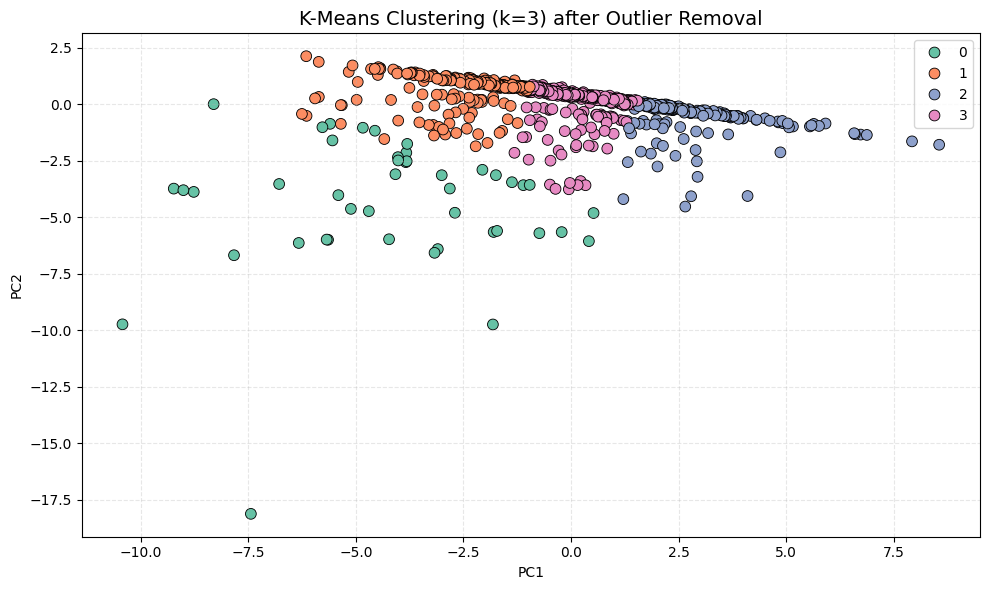

   Cluster  Avg_Cupper_Points Dominant_Processing_Method Dominant_Country  \
0        0           6.908864               Washed / Wet           Mexico   
1        1           7.100652               Washed / Wet           Mexico   
2        2           7.862886               Washed / Wet         Colombia   
3        3           7.531332               Washed / Wet           Mexico   

   Count  
0     44  
1    276  
2    246  
3    593  


In [151]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select sensory features
sensory_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body',
                'Balance', 'Uniformity', 'Clean Cup', 'Sweetness']

# Clean and filter the data
df_cluster = df[sensory_cols + ['Cupper Points', 'Processing Method', 'Country of Origin']].dropna().copy()

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[sensory_cols])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Remove outliers
mask = X_pca[:, 0] > -20
X_filtered = X_scaled[mask]
X_pca_filtered = X_pca[mask]
df_filtered = df_cluster.iloc[mask].copy()

# KMeans clustering (k=3)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_filtered)
df_filtered['Cluster'] = labels

# Plot PCA with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_filtered[:, 0], y=X_pca_filtered[:, 1],
                hue=labels, palette='Set2', s=60, edgecolor='black')
plt.title('K-Means Clustering (k=3) after Outlier Removal', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table per cluster
cluster_summary = df_filtered.groupby('Cluster').agg(
    Avg_Cupper_Points=('Cupper Points', 'mean'),
    Dominant_Processing_Method=('Processing Method', lambda x: x.value_counts().idxmax()),
    Dominant_Country=('Country of Origin', lambda x: x.value_counts().idxmax()),
    Count=('Cupper Points', 'count')
).reset_index()

print(cluster_summary)

#### מידת התרומה של שיטת העיבוד לציון הכללי והסובייקטיבי

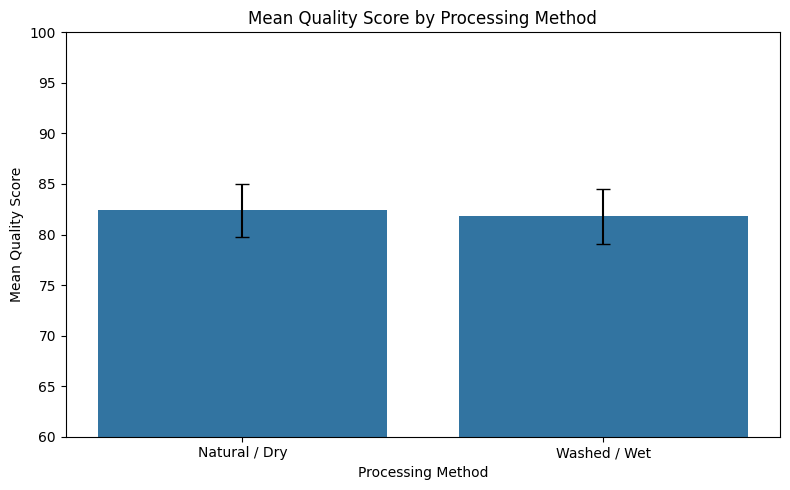

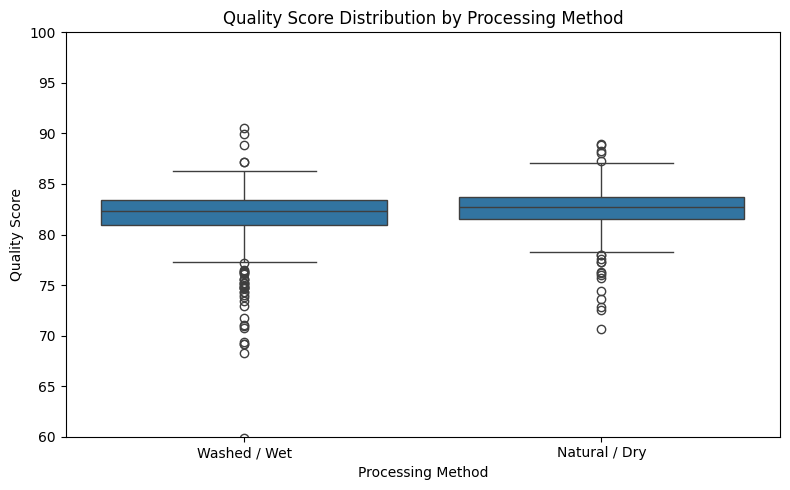

Observed Difference: -0.606
Permutation p-value: < 0.00001
✅ Statistically significant difference (Permutation Test).


In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the two most common processing methods
method_counts = df_top_countries['Processing Method'].value_counts()
top_methods = method_counts.nlargest(2).index.tolist()

# Filter the dataframe
df_top_methods = df_top_countries[df_top_countries['Processing Method'].isin(top_methods)].copy()

# Compute group means and standard deviations
summary = df_top_methods.groupby('Processing Method')['quality_score'].agg(['mean', 'std']).reset_index()

# Plot mean quality_score with error bars
plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x='Processing Method', y='mean', capsize=0.2)
for i, row in summary.iterrows():
    plt.errorbar(x=i, y=row['mean'], yerr=row['std'], fmt='none', color='black', capsize=5)
plt.title('Mean Quality Score by Processing Method')
plt.ylabel('Mean Quality Score')
plt.xlabel('Processing Method')
plt.ylim(60, 100)
plt.tight_layout()
plt.show()

# Boxplot for quality_score distribution
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_top_methods, x='Processing Method', y='quality_score')
plt.title('Quality Score Distribution by Processing Method')
plt.ylabel('Quality Score')
plt.xlabel('Processing Method')
plt.ylim(60, 100)
plt.tight_layout()
plt.show()

# Permutation Test
group1 = df_top_methods[df_top_methods['Processing Method'] == top_methods[0]]['quality_score']
group2 = df_top_methods[df_top_methods['Processing Method'] == top_methods[1]]['quality_score']

obs_diff = group1.mean() - group2.mean()
combined = np.concatenate([group1, group2])
n_permutations = 100000
diffs = []

for _ in range(n_permutations):
    np.random.shuffle(combined)
    perm_group1 = combined[:len(group1)]
    perm_group2 = combined[len(group1):]
    diffs.append(perm_group1.mean() - perm_group2.mean())

diffs = np.array(diffs)
p_perm = np.mean(np.abs(diffs) >= np.abs(obs_diff))

# Print results
print(f"Observed Difference: {obs_diff:.3f}")
print(f"Permutation p-value: < {1 / n_permutations:.5f}")

if p_perm < 0.05:
    print("✅ Statistically significant difference (Permutation Test).")
else:
    print("❌ No significant difference found (Permutation Test).")

In [153]:
import numpy as np
import pandas as pd
from IPython.display import display

# Step 1 – Identify the two most common processing methods
top_methods = df_top_countries['Processing Method'].value_counts().nlargest(2).index.tolist()

# Step 2 – Filter the data to include only those two methods
df_top_methods = df_top_countries[df_top_countries['Processing Method'].isin(top_methods)].copy()

# Step 3 – Define permutation test function
def permutation_test(data, group_col, value_col, group1, group2, n_permutations=100000):
    # Extract values for each group
    group1_vals = data[data[group_col] == group1][value_col].dropna()
    group2_vals = data[data[group_col] == group2][value_col].dropna()

    # Calculate observed difference in means
    observed_diff = group1_vals.mean() - group2_vals.mean()

    # Combine both groups for permutation
    combined = np.concatenate([group1_vals, group2_vals])
    diffs = []

    # Run permutations
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm1 = combined[:len(group1_vals)]
        perm2 = combined[len(group1_vals):]
        diffs.append(perm1.mean() - perm2.mean())

    # Calculate p-value
    diffs = np.array(diffs)
    p_val = np.mean(np.abs(diffs) >= np.abs(observed_diff))

    return observed_diff, p_val

# Step 4 – Run permutation tests for both metrics
obs_diff_quality, p_quality = permutation_test(
    df_top_methods, 'Processing Method', 'quality_score', top_methods[0], top_methods[1]
)

obs_diff_cupper, p_cupper = permutation_test(
    df_top_methods, 'Processing Method', 'Cupper Points', top_methods[0], top_methods[1]
)

# Step 5 – Create summary table with 6 decimal places
summary_table = pd.DataFrame({
    'Metric': ['Quality Score', 'Cupper Points'],
    'Observed Difference': [round(obs_diff_quality, 3), round(obs_diff_cupper, 3)],
    'Permutation p-value': [f"{p_quality:.6f}", f"{p_cupper:.6f}"]
})

# Step 6 – Display the table
display(summary_table)

Metric  Observed Difference Permutation p-value
0  Quality Score               -0.606            0.003840
1  Cupper Points               -0.174            0.000000

/tmp/ipython-input-3430292963.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=diff_df, x='Absolute Difference', y='Attribute', palette='muted')


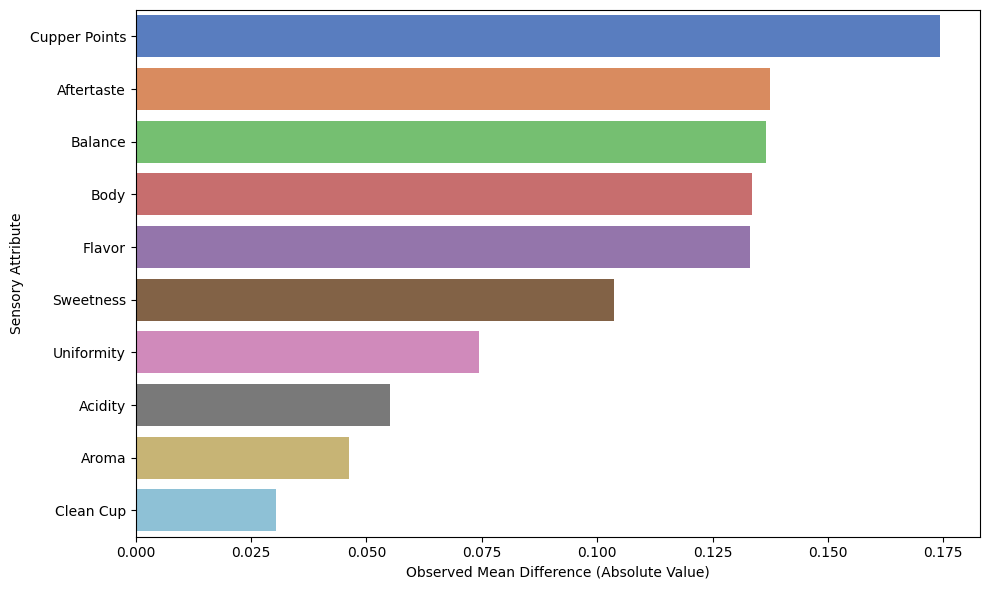

In [154]:
# Recreate df_top_methods with relevant sensory attributes included
sensory_components = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
    'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points'
]

# Add Processing Method for grouping
required_columns = sensory_components + ['Processing Method']
df_top_methods = df_top_countries[df_top_countries['Processing Method'].isin(top_methods)][required_columns].dropna()

# Compute differences
differences = {}
for feature in sensory_components:
    group1_vals = df_top_methods[df_top_methods['Processing Method'] == top_methods[0]][feature]
    group2_vals = df_top_methods[df_top_methods['Processing Method'] == top_methods[1]][feature]
    mean_diff = group1_vals.mean() - group2_vals.mean()
    differences[feature] = mean_diff

# Convert to DataFrame
diff_df = pd.DataFrame.from_dict(differences, orient='index', columns=['Observed Difference'])
diff_df['Absolute Difference'] = diff_df['Observed Difference'].abs()
diff_df = diff_df.sort_values(by='Absolute Difference', ascending=False).reset_index()
diff_df.rename(columns={'index': 'Attribute'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=diff_df, x='Absolute Difference', y='Attribute', palette='muted')
plt.xlabel('Observed Mean Difference (Absolute Value)')
plt.ylabel('Sensory Attribute')
plt.tight_layout()
plt.show()

In [155]:
# Create comparison table between the two processing methods
rows = []

for feature in sensory_components:
    vals1 = df_top_methods[df_top_methods['Processing Method'] == top_methods[0]][feature].dropna()
    vals2 = df_top_methods[df_top_methods['Processing Method'] == top_methods[1]][feature].dropna()
    mean1 = vals1.mean()
    mean2 = vals2.mean()
    diff = mean1 - mean2
    rows.append({
        'Attribute': feature,
        f'{top_methods[0]} Mean': round(mean1, 3),
        f'{top_methods[1]} Mean': round(mean2, 3),
        'Difference (Method1 - Method2)': round(diff, 3)
    })

# Convert to DataFrame and sort
comparison_df = pd.DataFrame(rows)
comparison_df['|Difference|'] = comparison_df['Difference (Method1 - Method2)'].abs()
comparison_df = comparison_df.sort_values(by='|Difference|', ascending=False).drop(columns='|Difference|')

# Display the DataFrame
print(comparison_df.to_string(index=False))

    Attribute  Washed / Wet Mean  Natural / Dry Mean  Difference (Method1 - Method2)
Cupper Points              7.418               7.592                          -0.174
   Aftertaste              7.335               7.473                          -0.137
      Balance              7.460               7.597                          -0.137
         Body              7.468               7.601                          -0.134
       Flavor              7.462               7.595                          -0.133
    Sweetness              9.935               9.831                           0.104
   Uniformity              9.845               9.770                           0.074
      Acidity              7.513               7.568                          -0.055
        Aroma              7.537               7.584                          -0.046
    Clean Cup              9.819               9.789                           0.030


#### מידת התרומה של המדינה

/tmp/ipython-input-186015512.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delta_df, x='Delta vs Reference', y='Country', palette='coolwarm')


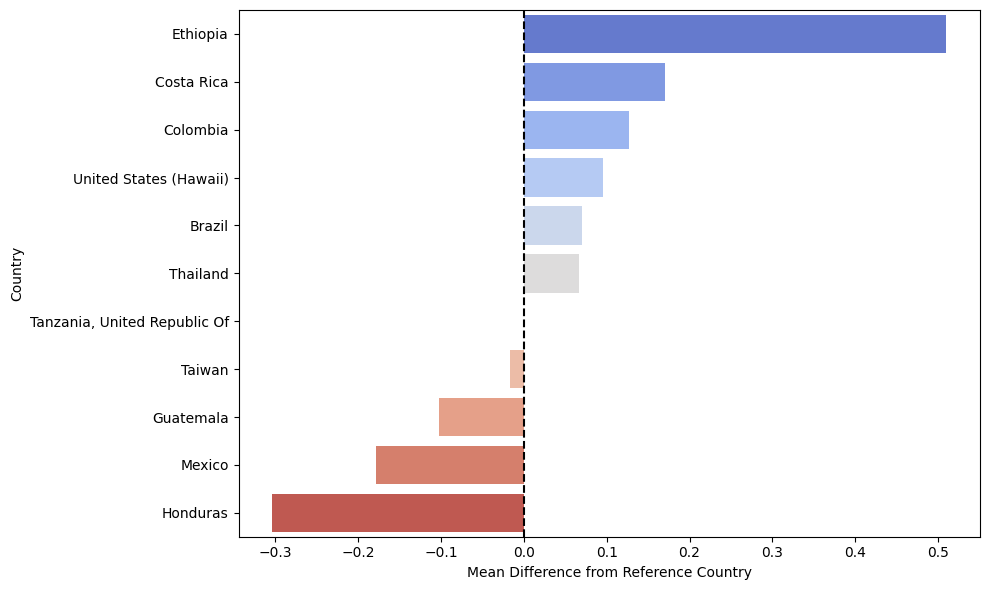

In [156]:
# Recompute with all eligible countries (11 countries with at least 30 samples)
country_counts = df_top_countries['Country of Origin'].value_counts()
eligible_countries = country_counts[country_counts >= 30].index.tolist()

# Filter only these countries
df_countries = df_top_countries[df_top_countries['Country of Origin'].isin(eligible_countries)]

# Compute mean Cupper Points per country
country_means = df_countries.groupby('Country of Origin')['Cupper Points'].mean()

# Compute overall mean and find reference country (closest to the mean)
overall_mean = df_countries['Cupper Points'].mean()
reference_country = (country_means - overall_mean).abs().idxmin()
reference_value = country_means[reference_country]

# Build delta table
delta_df = pd.DataFrame({
    'Country': country_means.index,
    'Mean Cupper Points': country_means.values
})
delta_df['Delta vs Reference'] = delta_df['Mean Cupper Points'] - reference_value

# Sort for visualization
delta_df = delta_df.sort_values(by='Delta vs Reference', ascending=False)

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=delta_df, x='Delta vs Reference', y='Country', palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Mean Difference from Reference Country')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [157]:
import pandas as pd
import numpy as np

# Sensory attributes including Cupper Points
sensory_attributes = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
    'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points'
]

# Filter only the necessary columns
df_sensory = df_countries[['Country of Origin'] + sensory_attributes].dropna()

# Compute mean of each sensory attribute by country
country_sensory_means = df_sensory.groupby('Country of Origin')[sensory_attributes].mean()

# Compute overall means
overall_mean = df_sensory[sensory_attributes].mean()

# Compute deviation from global mean
delta_table = country_sensory_means.subtract(overall_mean).round(3)
delta_table.reset_index(inplace=True)

# Function to apply color style
def color_val(val):
    color = 'green' if val > 0 else 'red' if val < 0 else 'black'
    return f'color: {color}'

# Apply styling
styled_table = delta_table.style.applymap(color_val, subset=sensory_attributes)

# Display styled table (in Jupyter/Colab)
styled_table

/tmp/ipython-input-3809386487.py:29: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = delta_table.style.applymap(color_val, subset=sensory_attributes)


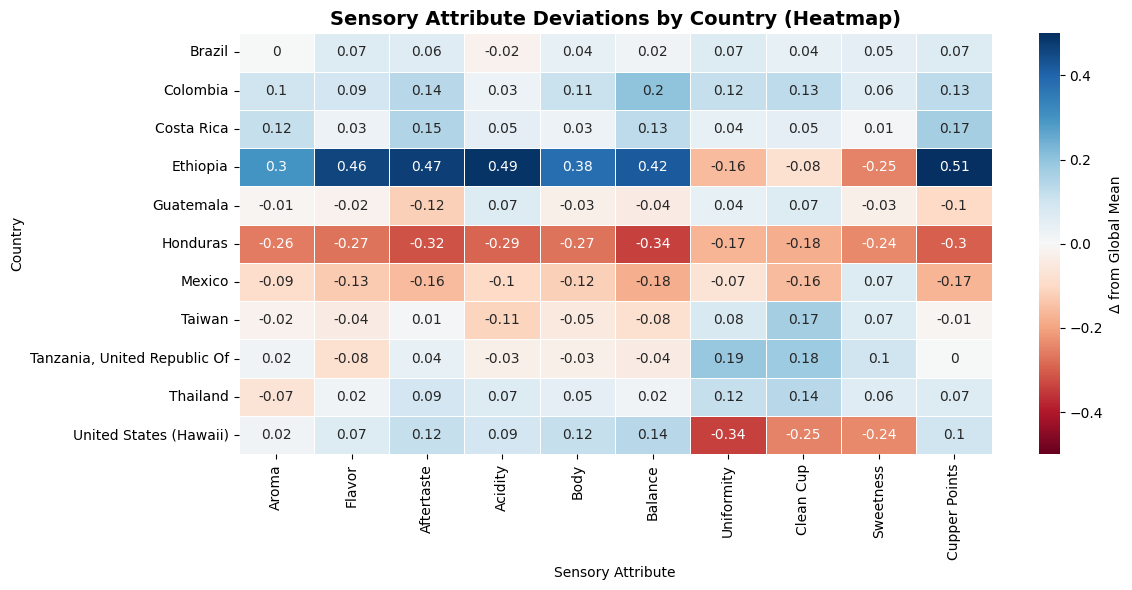

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define sensory attributes
sensory_attributes = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
    'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points'
]

# Filter only relevant columns and drop missing values
df_sensory = df_countries[['Country of Origin'] + sensory_attributes].dropna()

# Compute mean sensory scores per country
country_sensory_means = df_sensory.groupby('Country of Origin')[sensory_attributes].mean()

# Compute global mean for each attribute
overall_mean = df_sensory[sensory_attributes].mean()

# Calculate delta: deviation from global mean
delta_table = country_sensory_means.subtract(overall_mean).round(2)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    delta_table,
    annot=True,
    cmap='RdBu',              # Blue = higher than mean, Red = lower
    center=0,
    linewidths=0.5,
    vmin=-0.5, vmax=0.5,      # Fix color range
    cbar_kws={'label': 'Δ from Global Mean'}
)
plt.title("Sensory Attribute Deviations by Country (Heatmap)", fontsize=14, weight='bold')
plt.xlabel("Sensory Attribute")
plt.ylabel("Country")
plt.tight_layout()

# Save to file
plt.savefig("sensory_deviation_heatmap.png", dpi=300)
plt.show()

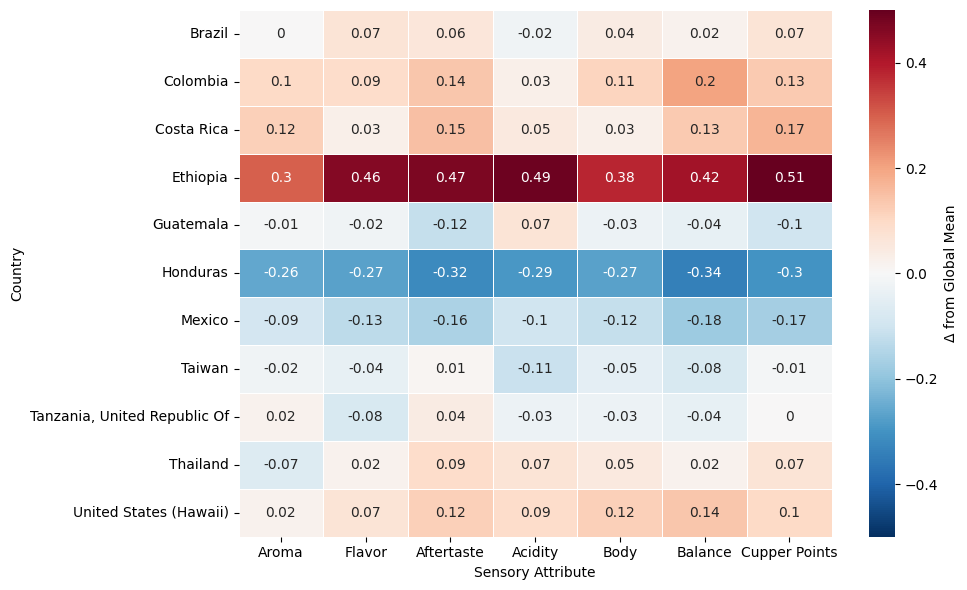

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define filtered sensory attributes
filtered_attributes = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Cupper Points'
]

# Filter and drop missing values
df_sensory_filtered = df_countries[['Country of Origin'] + filtered_attributes].dropna()

# Compute means per country
country_sensory_means = df_sensory_filtered.groupby('Country of Origin')[filtered_attributes].mean()

# Compute global mean
overall_mean = df_sensory_filtered[filtered_attributes].mean()

# Calculate delta from global mean
delta_table = country_sensory_means.subtract(overall_mean).round(2)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    delta_table,
    annot=True,
    cmap='RdBu_r',           # Red = positive deviation, Blue = negative
    center=0,
    linewidths=0.5,
    vmin=-0.5, vmax=0.5,
    cbar_kws={'label': 'Δ from Global Mean'}
)

plt.xlabel("Sensory Attribute")
plt.ylabel("Country")
plt.tight_layout()

# Save the plot
plt.savefig("sensory_deviation_filtered_heatmap.png", dpi=300)
plt.show()

## הרצת מודלים

In [160]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Define all sensory features
sensory_features = [
    'Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance',
    'Uniformity', 'Clean Cup', 'Sweetness'
]

# Drop rows with missing values in sensory features or target
df_sensory_only = df_top_countries.dropna(subset=sensory_features + ['Cupper Points'])

# Split into X and y
X = df_sensory_only[sensory_features]
y = df_sensory_only['Cupper Points']

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Calculate R²
r2 = model.score(X, y)

# Print results
print(f"🎯 R² (Sensory Only): {r2:.3f}")
print("\n📋 Coefficients:")
for feature, coef in zip(sensory_features, model.coef_):
    print(f"{feature}: {coef:.3f}")

🎯 R² (Sensory Only): 0.696

📋 Coefficients:
Aroma: 0.050
Flavor: 0.418
Aftertaste: 0.281
Acidity: 0.046
Body: 0.042
Balance: 0.207
Uniformity: 0.018
Clean Cup: 0.018
Sweetness: -0.035


### ריגרסיה לינארית מרובת משתנים- לאסו

In [161]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Sensory only
sensory_features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance']
target = 'Cupper Points'

df1 = df_top_countries.dropna(subset=sensory_features + [target])
X1 = df1[sensory_features]
y1 = df1[target]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)

pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])
pipe1.fit(X1_train, y1_train)
y1_pred = pipe1.predict(X1_test)
print("----- Model 1: Sensory Only -----")
print(f"Lambda: {pipe1.named_steps['lasso'].alpha_:.5f}")
print(f"R²: {r2_score(y1_test, y1_pred):.3f}\n")

# 2. Sensory + Country
df2 = df_top_countries.dropna(subset=sensory_features + ['Country (Cleaned)'] + [target])
X2 = df2[sensory_features + ['Country (Cleaned)']]
y2 = df2[target]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

preprocessor2 = ColumnTransformer([
    ('num', StandardScaler(), sensory_features),
    ('cat', OneHotEncoder(drop='first'), ['Country (Cleaned)'])
])

pipe2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('lasso', LassoCV(cv=5, random_state=42))
])
pipe2.fit(X2_train, y2_train)
y2_pred = pipe2.predict(X2_test)
print("----- Model 2: Sensory + Country -----")
print(f"Lambda: {pipe2.named_steps['lasso'].alpha_:.5f}")
print(f"R²: {r2_score(y2_test, y2_pred):.3f}\n")

# 3. Sensory + Country + Processing Method (top 2 only)
top_methods = df_top_countries['Processing Method'].value_counts().nlargest(2).index.tolist()
df3 = df_top_countries[df_top_countries['Processing Method'].isin(top_methods)].dropna(
    subset=sensory_features + ['Country (Cleaned)', 'Processing Method'] + [target]
)
X3 = df3[sensory_features + ['Country (Cleaned)', 'Processing Method']]
y3 = df3[target]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

preprocessor3 = ColumnTransformer([
    ('num', StandardScaler(), sensory_features),
    ('cat', OneHotEncoder(drop='first'), ['Country (Cleaned)', 'Processing Method'])
])

pipe3 = Pipeline([
    ('preprocessor', preprocessor3),
    ('lasso', LassoCV(cv=5, random_state=42))
])
pipe3.fit(X3_train, y3_train)
y3_pred = pipe3.predict(X3_test)
print("----- Model 3: Sensory + Country + Processing Method (Top 2) -----")
print(f"Lambda: {pipe3.named_steps['lasso'].alpha_:.5f}")
print(f"R²: {r2_score(y3_test, y3_pred):.3f}")
LassoCV(cv=5, random_state=42)

----- Model 1: Sensory Only -----
Lambda: 0.00762
R²: 0.739

----- Model 2: Sensory + Country -----
Lambda: 0.00618
R²: 0.741

----- Model 3: Sensory + Country + Processing Method (Top 2) -----
Lambda: 0.00056
R²: 0.742


LassoCV(cv=5, random_state=42)

### רנדום פורסט

In [162]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# --- Input variables ---
sensory_features = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance']
target = 'Cupper Points'

# --- Model 1: Sensory Only ---
df1 = df_countries.dropna(subset=sensory_features + [target])
X1 = df1[sensory_features]
y1 = df1[target]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)

pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=5,
        random_state=42))
])
pipe1.fit(X1_train, y1_train)
y1_pred = pipe1.predict(X1_test)

print("----- RF Model 1: Sensory Only -----")
print(f"Test R²: {r2_score(y1_test, y1_pred):.3f}")
print(f"Train R²: {r2_score(y1_train, pipe1.predict(X1_train)):.3f}\n")


# --- Model 2: Sensory + Country ---
df2 = df_countries.dropna(subset=sensory_features + ['Country (Cleaned)'] + [target])
X2 = df2[sensory_features + ['Country (Cleaned)']]
y2 = df2[target]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

preprocessor2 = ColumnTransformer([
    ('num', StandardScaler(), sensory_features),
    ('cat', OneHotEncoder(drop='first'), ['Country (Cleaned)'])
])

pipe2 = Pipeline([
    ('preprocessor', preprocessor2),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=5,
        random_state=42))
])
pipe2.fit(X2_train, y2_train)
y2_pred = pipe2.predict(X2_test)

print("----- RF Model 2: Sensory + Country -----")
print(f"Test R²: {r2_score(y2_test, y2_pred):.3f}")
print(f"Train R²: {r2_score(y2_train, pipe2.predict(X2_train)):.3f}\n")


# --- Model 3: Sensory + Country + Processing Method (Top 2) ---
top_methods = df_countries['Processing Method'].value_counts().nlargest(2).index.tolist()
df3 = df_countries[df_countries['Processing Method'].isin(top_methods)].dropna(
    subset=sensory_features + ['Country (Cleaned)', 'Processing Method'] + [target]
)
X3 = df3[sensory_features + ['Country (Cleaned)', 'Processing Method']]
y3 = df3[target]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

preprocessor3 = ColumnTransformer([
    ('num', StandardScaler(), sensory_features),
    ('cat', OneHotEncoder(drop='first'), ['Country (Cleaned)', 'Processing Method'])
])

pipe3 = Pipeline([
    ('preprocessor', preprocessor3),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=5,
        random_state=42))
])
pipe3.fit(X3_train, y3_train)
y3_pred = pipe3.predict(X3_test)

print("----- RF Model 3: Sensory + Country + Processing Method (Top 2) -----")
print(f"Test R²: {r2_score(y3_test, y3_pred):.3f}")
print(f"Train R²: {r2_score(y3_train, pipe3.predict(X3_train)):.3f}")

----- RF Model 1: Sensory Only -----
Test R²: 0.701
Train R²: 0.624

----- RF Model 2: Sensory + Country -----
Test R²: 0.702
Train R²: 0.628

----- RF Model 3: Sensory + Country + Processing Method (Top 2) -----
Test R²: 0.743
Train R²: 0.808


In [163]:
print(f"Train R²: {r2_score(y3_train, pipe3.predict(X3_train)):.3f}")

Train R²: 0.808


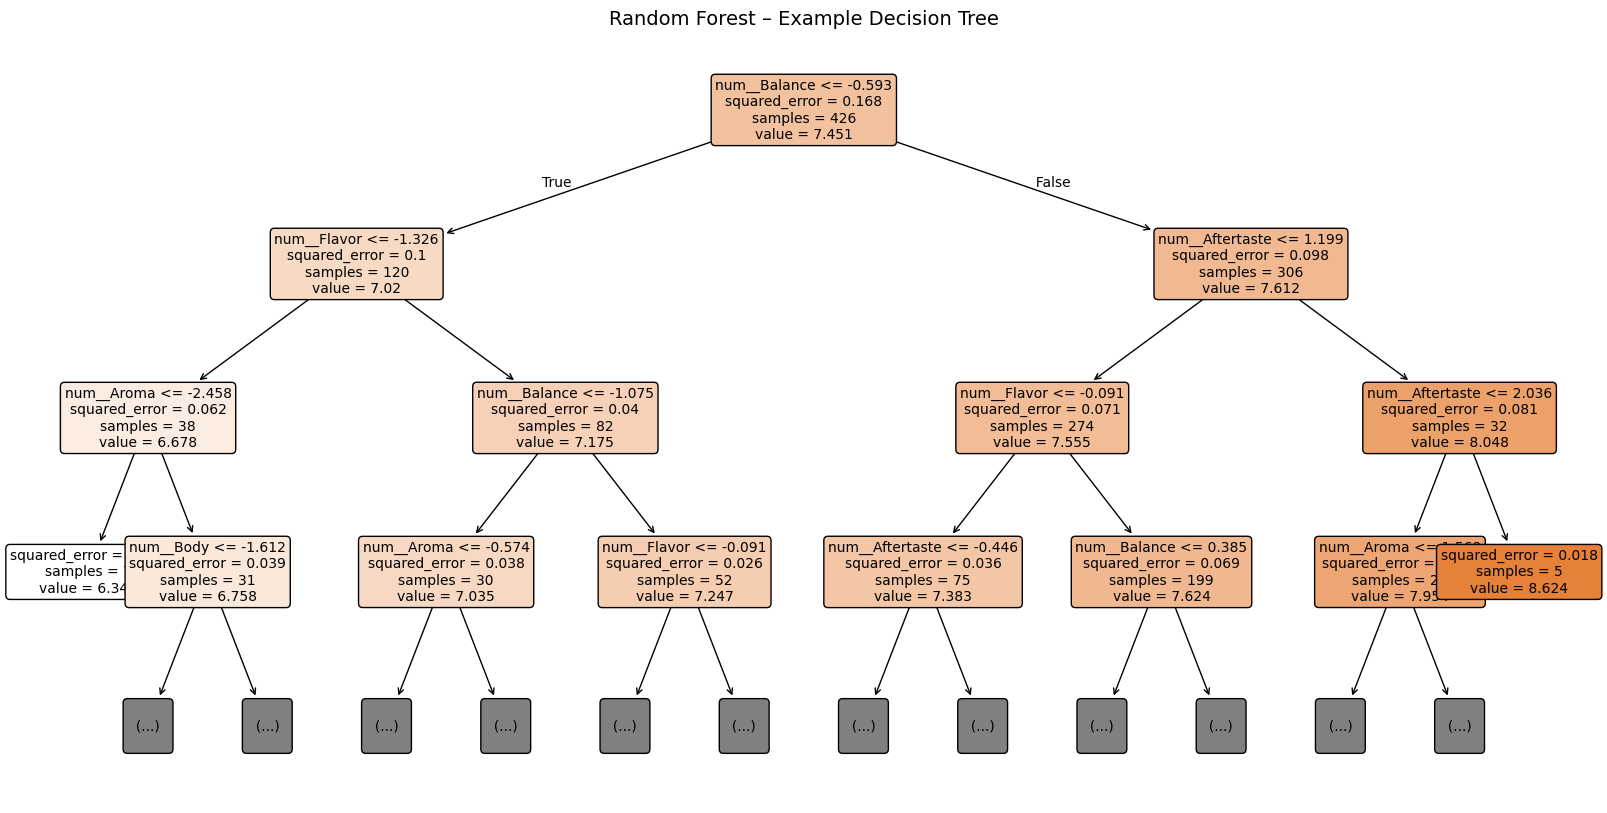

In [164]:
from sklearn.tree import plot_tree

# שליפת המודל המאומן מתוך הפייפליין
rf_model = pipe3.named_steps['rf']
preprocessor = pipe3.named_steps['preprocessor']

# שמות הפיצ'רים אחרי טרנספורמציה (כולל one-hot)
feature_names = preprocessor.get_feature_names_out()

# ציור של עץ אחד מתוך היער
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=feature_names,
          filled=True,
          rounded=True,
          max_depth=3,           # אפשר להגדיל ל-4–5 אם עדיין קריא
          fontsize=10)
plt.title("Random Forest – Example Decision Tree", fontsize=14)
plt.show()

/tmp/ipython-input-1485789645.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=feat_imp.head(12), x='Importance', y='Feature', palette='viridis')


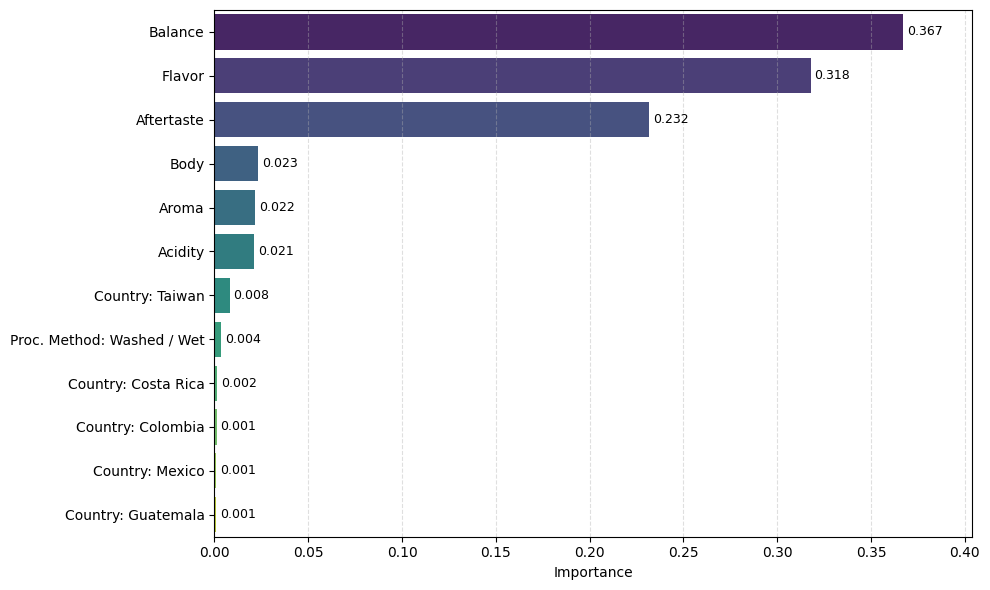

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature names and importance scores from the pipeline
feature_names = pipe3.named_steps['preprocessor'].get_feature_names_out()
importances = pipe3.named_steps['rf'].feature_importances_

# Clean up feature names for display
clean_names = []
for name in feature_names:
    name = name.replace('num__', '')\
               .replace('cat__Country (Cleaned)_', 'Country: ')\
               .replace('cat__Processing Method_', 'Proc. Method: ')
    clean_names.append(name)

# Create a DataFrame for feature importance
feat_imp = pd.DataFrame({
    'Feature': clean_names,
    'RawFeature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=feat_imp.head(12), x='Importance', y='Feature', palette='viridis')

# Add value labels to each bar
for i, value in enumerate(feat_imp.head(12)['Importance']):
    ax.text(value + 0.002, i, f"{value:.3f}", va='center', fontsize=9)

# Adjust x-axis limits to show small values clearly
plt.xlim(0, feat_imp['Importance'].max() * 1.1)
plt.xlabel('Importance')
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()